In [ ]:
!pip install pydicom
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 109.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 95.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

In [ ]:

import matplotlib.pyplot as plt
import os
import time
import numpy as np
import glob
import json
import collections
import torch
import torch.nn as nn

import pydicom as dicom
import matplotlib.patches as patches

from matplotlib import animation, rc
import pandas as pd

import pydicom as dicom # dicom
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_path = "/content/drive/MyDrive/FYPDataset/rsna-2024-lumbar-spine-degenerative-classification/"
train  = pd.read_csv(train_path + 'train.csv')
label = pd.read_csv(train_path + 'train_label_coordinates.csv')
train_desc  = pd.read_csv(train_path + 'train_series_descriptions.csv')
test_desc   = pd.read_csv(train_path + 'test_series_descriptions.csv')
sub         = pd.read_csv(train_path + 'sample_submission.csv')

print(train_path+'train_csv')
print(train_path+'train_label_coordinates.csv')
print(train_path+'train_series_descriptions.csv')
print(train_path+'sample_submission.csv')



/content/drive/MyDrive/FYPDataset/rsna-2024-lumbar-spine-degenerative-classification/train_csv
/content/drive/MyDrive/FYPDataset/rsna-2024-lumbar-spine-degenerative-classification/train_label_coordinates.csv
/content/drive/MyDrive/FYPDataset/rsna-2024-lumbar-spine-degenerative-classification/train_series_descriptions.csv
/content/drive/MyDrive/FYPDataset/rsna-2024-lumbar-spine-degenerative-classification/sample_submission.csv


In [ ]:
train_desc.head(10)

,study_id,series_id,series_description
0,4003253,702807833,Sagittal T2/STIR
1,4003253,1054713880,Sagittal T1
2,4003253,2448190387,Axial T2
3,4646740,3201256954,Axial T2
4,4646740,3486248476,Sagittal T1
5,4646740,3666319702,Sagittal T2/STIR
6,7143189,132939515,Sagittal T2/STIR
7,7143189,1951927562,Axial T2
8,7143189,3219733239,Sagittal T1
9,8785691,481125819,Sagittal T2/STIR


In [ ]:
label.head(5)

,study_id,series_id,instance_number,condition,level,x,y
0,4003253,702807833,8,Spinal Canal Stenosis,L1/L2,322.831858,227.964602
1,4003253,702807833,8,Spinal Canal Stenosis,L2/L3,320.571429,295.714286
2,4003253,702807833,8,Spinal Canal Stenosis,L3/L4,323.030303,371.818182
3,4003253,702807833,8,Spinal Canal Stenosis,L4/L5,335.292035,427.327434
4,4003253,702807833,8,Spinal Canal Stenosis,L5/S1,353.415929,483.964602


In [ ]:
def generate_image_paths(df, data_dir):
    image_paths = []
    for study_id, series_id in zip(df['study_id'], df['series_id']):
        study_dir = os.path.join(data_dir, str(study_id))
        series_dir = os.path.join(study_dir, str(series_id))
        images = os.listdir(series_dir)
        image_paths.extend([os.path.join(series_dir, img) for img in images])
    return image_paths

In [ ]:
# Read image paths from the text file
train_image_paths = []
with open("/content/drive/MyDrive/FYPDataset/train_image_paths.txt", "r") as file:
    train_image_paths = [line.strip() for line in file.readlines()]

print(f"Loaded {len(train_image_paths)} train image paths.")

# Read image paths from the text file
test_image_paths = []
with open("/content/drive/MyDrive/FYPDataset/test_image_paths.txt", "r") as file:
    test_image_paths = [line.strip() for line in file.readlines()]

print(f"Loaded {len(test_image_paths)} test image paths.")


print(train_image_paths[2])
#train_image_paths = generate_image_paths(train_desc, f'{train_path}train_images')
#test_image_paths = generate_image_paths(test_desc, f'{train_path}test_images')

Loaded 147219 train image paths.
Loaded 97 test image paths.
/content/drive/MyDrive/FYPDataset/rsna-2024-lumbar-spine-degenerative-classification//train_images/4003253/702807833/12.dcm


In [ ]:
train_image_paths = [path.replace(os.sep, '/') for path in train_image_paths]
len(train_image_paths)
print(train_image_paths[2])

/content/drive/MyDrive/FYPDataset/rsna-2024-lumbar-spine-degenerative-classification//train_images/4003253/702807833/12.dcm


In [ ]:
len(test_image_paths)

97

In [ ]:
len(train_desc)

6294

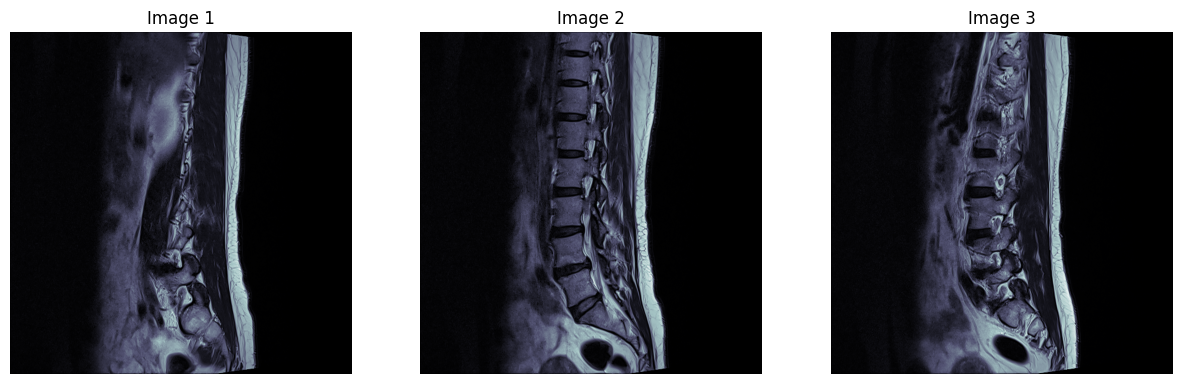

In [ ]:
import pydicom
import matplotlib.pyplot as plt

# Function to open and display DICOM images
def display_dicom_images(image_paths):
    plt.figure(figsize=(15, 5))  # Adjust figure size if needed
    for i, path in enumerate(image_paths[:3]):
        ds = pydicom.dcmread(path)
        plt.subplot(1, 3, i+1)
        plt.imshow(ds.pixel_array, cmap=plt.cm.bone)
        plt.title(f"Image {i+1}")
        plt.axis('off')
    plt.show()

# Display the first three DICOM images
display_dicom_images(train_image_paths)

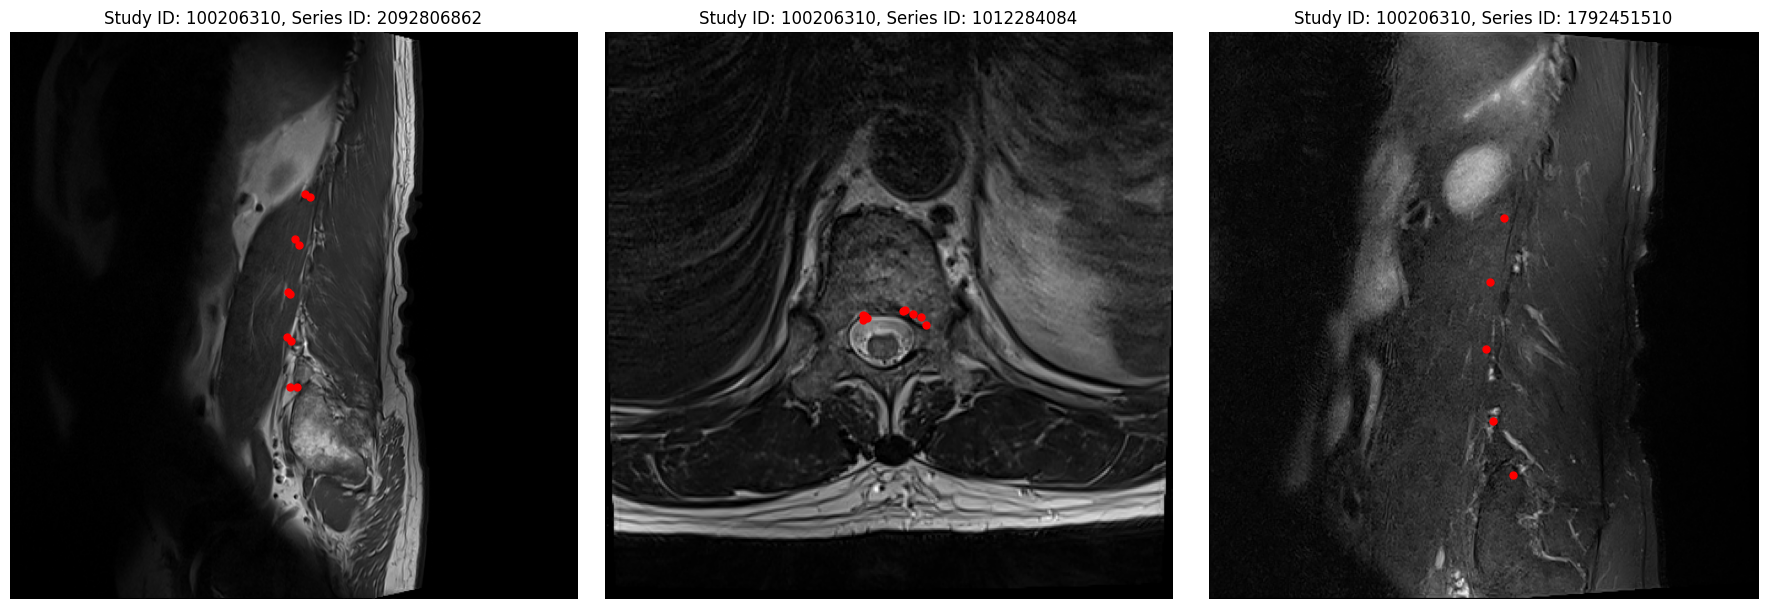

In [ ]:
import os
import pydicom
import matplotlib.pyplot as plt
import pandas as pd

# Function to open and display DICOM images along with coordinates
def display_dicom_with_coordinates(image_paths, label_df):
    fig, axs = plt.subplots(1, len(image_paths), figsize=(18, 6))

    for idx, path in enumerate(image_paths):  # Display images
        study_id = int(path.split(os.sep)[-3])
        series_id = int(path.split(os.sep)[-2])

        # Filter label coordinates for the current study and series
        filtered_labels = label_df[(label_df['study_id'] == study_id) & (label_df['series_id'] == series_id)]

        # Read DICOM image
        ds = pydicom.dcmread(path)

        # Plot DICOM image
        axs[idx].imshow(ds.pixel_array, cmap='gray')
        axs[idx].set_title(f"Study ID: {study_id}, Series ID: {series_id}")
        axs[idx].axis('off')

        # Plot coordinates
        for _, row in filtered_labels.iterrows():
            axs[idx].plot(row['x'], row['y'], 'ro', markersize=5)

    plt.tight_layout()
    plt.show()

# Load DICOM files from a folder
def load_dicom_files(path_to_folder):
    files = [os.path.join(path_to_folder, f) for f in os.listdir(path_to_folder) if f.endswith('.dcm')]
    files.sort(key=lambda x: int(os.path.splitext(os.path.basename(x))[0].split('-')[-1]))
    return files

# Display DICOM images with coordinates
study_id = "100206310"
# study_folder = f'{train_path}/train_images/{study_id}'
study_folder = os.path.join(train_path, 'train_images', study_id)

image_paths = []
for series_folder in os.listdir(study_folder):
    series_folder_path = os.path.join(study_folder, series_folder)
    dicom_files = load_dicom_files(series_folder_path)
    if dicom_files:
        image_paths.append(dicom_files[0])  # Add the first image from each series


display_dicom_with_coordinates(image_paths, label)

**Data Preprocessing**

In [ ]:
# Define function to reshape a single row of the DataFrame
def reshape_row(row):
    data = {'study_id': [], 'condition': [], 'level': [], 'severity': []}

    for column, value in row.items():
        if column not in ['study_id', 'series_id', 'instance_number', 'x', 'y', 'series_description']:
            parts = column.split('_')
            condition = ' '.join([word.capitalize() for word in parts[:-2]])
            level = parts[-2].capitalize() + '/' + parts[-1].capitalize()
            data['study_id'].append(row['study_id'])
            data['condition'].append(condition)
            data['level'].append(level)
            data['severity'].append(value)

    return pd.DataFrame(data)

# Reshape the DataFrame for all rows
new_train_df = pd.concat([reshape_row(row) for _, row in train.iterrows()], ignore_index=True)

# Display the first few rows of the reshaped dataframe
new_train_df.head(5)


,study_id,condition,level,severity
0,4003253,Spinal Canal Stenosis,L1/L2,Normal/Mild
1,4003253,Spinal Canal Stenosis,L2/L3,Normal/Mild
2,4003253,Spinal Canal Stenosis,L3/L4,Normal/Mild
3,4003253,Spinal Canal Stenosis,L4/L5,Normal/Mild
4,4003253,Spinal Canal Stenosis,L5/S1,Normal/Mild


In [ ]:
# Print columns in a neat way
print("\nColumns in new_train_df:")
print(",".join(new_train_df.columns))

print("\nColumns in label:")
print(",".join(label.columns))

print("\nColumns in test_desc:")
print(",".join(test_desc.columns))

print("\nColumns in sub:")
print(",".join(sub.columns))


Columns in new_train_df:
study_id,condition,level,severity

Columns in label:
study_id,series_id,instance_number,condition,level,x,y

Columns in test_desc:
study_id,series_id,series_description

Columns in sub:
row_id,normal_mild,moderate,severe


In [ ]:
# Merge the dataframes on the common columns
merged_df = pd.merge(new_train_df, label, on=['study_id', 'condition', 'level'], how='inner')
# Merge the dataframes on the common column 'series_id'
final_merged_df = pd.merge(merged_df, train_desc, on='series_id', how='inner')

In [ ]:
# Merge the dataframes on the common column 'series_id'
final_merged_df = pd.merge(merged_df, train_desc, on=['series_id','study_id'], how='inner')
# Display the first few rows of the final merged dataframe
final_merged_df.head(5)

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description
0,4003253,Spinal Canal Stenosis,L1/L2,Normal/Mild,702807833,8,322.831858,227.964602,Sagittal T2/STIR
1,4003253,Spinal Canal Stenosis,L2/L3,Normal/Mild,702807833,8,320.571429,295.714286,Sagittal T2/STIR
2,4003253,Spinal Canal Stenosis,L3/L4,Normal/Mild,702807833,8,323.030303,371.818182,Sagittal T2/STIR
3,4003253,Spinal Canal Stenosis,L4/L5,Normal/Mild,702807833,8,335.292035,427.327434,Sagittal T2/STIR
4,4003253,Spinal Canal Stenosis,L5/S1,Normal/Mild,702807833,8,353.415929,483.964602,Sagittal T2/STIR


In [ ]:
final_merged_df[final_merged_df['series_id'] == 1012284084].sort_values("instance_number")

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description
1127,100206310,Left Subarticular Stenosis,L1/L2,Normal/Mild,1012284084,20,180.355677,165.034200,Axial T2
1132,100206310,Right Subarticular Stenosis,L1/L2,Normal/Mild,1012284084,20,145.120536,162.285714,Axial T2
1128,100206310,Left Subarticular Stenosis,L2/L3,Normal/Mild,1012284084,28,177.729138,160.218878,Axial T2
1133,100206310,Right Subarticular Stenosis,L2/L3,Normal/Mild,1012284084,28,145.691964,160.000000,Axial T2
1129,100206310,Left Subarticular Stenosis,L3/L4,Moderate,1012284084,37,173.351573,158.467852,Axial T2
1134,100206310,Right Subarticular Stenosis,L3/L4,Moderate,1012284084,37,147.406250,161.142857,Axial T2
1130,100206310,Left Subarticular Stenosis,L4/L5,Severe,1012284084,46,168.536252,156.279070,Axial T2
1135,100206310,Right Subarticular Stenosis,L4/L5,Moderate,1012284084,46,146.263393,160.000000,Axial T2
1131,100206310,Left Subarticular Stenosis,L5/S1,Moderate,1012284084,55,167.660739,157.154583,Axial T2
1136,100206310,Right Subarticular Stenosis,L5/S1,Moderate,1012284084,55,145.120536,159.428571,Axial T2


In [ ]:
# Filter the dataframe for the given study_id and sort by instance_number
filtered_df = final_merged_df[final_merged_df['study_id'] == 1013589491].sort_values("instance_number")

# Display the resulting dataframe
filtered_df


,study_id,condition,level,severity,series_id,instance_number,x,y,series_description
11430,1013589491,Left Neural Foraminal Narrowing,L5/S1,Normal/Mild,2391548363,6,240.770301,411.216131,Sagittal T1
11445,1013589491,Right Subarticular Stenosis,L5/S1,Normal/Mild,598943280,7,231.484002,293.409742,Axial T2
11440,1013589491,Left Subarticular Stenosis,L5/S1,Normal/Mild,598943280,7,277.947591,296.033812,Axial T2
11429,1013589491,Left Neural Foraminal Narrowing,L4/L5,Normal/Mild,2391548363,7,227.194543,355.943404,Sagittal T1
11428,1013589491,Left Neural Foraminal Narrowing,L3/L4,Normal/Mild,2391548363,7,222.346058,293.844904,Sagittal T1
11426,1013589491,Left Neural Foraminal Narrowing,L1/L2,Normal/Mild,2391548363,7,247.558179,177.458555,Sagittal T1
11427,1013589491,Left Neural Foraminal Narrowing,L2/L3,Normal/Mild,2391548363,7,233.012725,234.685828,Sagittal T1
11421,1013589491,Spinal Canal Stenosis,L1/L2,Normal/Mild,482346415,10,245.476038,189.689334,Sagittal T2/STIR
11424,1013589491,Spinal Canal Stenosis,L4/L5,Moderate,482346415,10,238.435979,366.511699,Sagittal T2/STIR
11423,1013589491,Spinal Canal Stenosis,L3/L4,Moderate,482346415,10,232.381129,310.201597,Sagittal T2/STIR


In [ ]:
# Sort final_merged_df by study_id, series_id, and series_description
sorted_final_merged_df = final_merged_df[final_merged_df['study_id'] == 1013589491].sort_values(by=['series_id', 'series_description', 'instance_number'])
sorted_final_merged_df

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description
11421,1013589491,Spinal Canal Stenosis,L1/L2,Normal/Mild,482346415,10,245.476038,189.689334,Sagittal T2/STIR
11422,1013589491,Spinal Canal Stenosis,L2/L3,Normal/Mild,482346415,10,235.251580,250.434645,Sagittal T2/STIR
11423,1013589491,Spinal Canal Stenosis,L3/L4,Moderate,482346415,10,232.381129,310.201597,Sagittal T2/STIR
11424,1013589491,Spinal Canal Stenosis,L4/L5,Moderate,482346415,10,238.435979,366.511699,Sagittal T2/STIR
11425,1013589491,Spinal Canal Stenosis,L5/S1,Normal/Mild,482346415,10,257.921341,421.652869,Sagittal T2/STIR
11440,1013589491,Left Subarticular Stenosis,L5/S1,Normal/Mild,598943280,7,277.947591,296.033812,Axial T2
11445,1013589491,Right Subarticular Stenosis,L5/S1,Normal/Mild,598943280,7,231.484002,293.409742,Axial T2
11439,1013589491,Left Subarticular Stenosis,L4/L5,Moderate,598943280,13,266.694844,257.081995,Axial T2
11444,1013589491,Right Subarticular Stenosis,L4/L5,Normal/Mild,598943280,13,228.060888,255.755492,Axial T2
11438,1013589491,Left Subarticular Stenosis,L3/L4,Moderate,598943280,19,262.366864,246.262046,Axial T2


In [ ]:
import pandas as pd

# Create the row_id column
final_merged_df['row_id'] = (
    final_merged_df['study_id'].astype(str) + '_' +
    final_merged_df['condition'].str.lower().str.replace(' ', '_') + '_' +
    final_merged_df['level'].str.lower().str.replace('/', '_')
)

# Create the image_path column
final_merged_df['image_path'] = (
    f'{train_path}/train_images/' +
    final_merged_df['study_id'].astype(str) + '/' +
    final_merged_df['series_id'].astype(str) + '/' +
    final_merged_df['instance_number'].astype(str) + '.dcm'
)

# Note: Check image path, since there's 1 instance id, for 1 image, but there's many more images other than the ones labelled in the instance ID.

# Display the updated dataframe
final_merged_df

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description,row_id,image_path
0,4003253,Spinal Canal Stenosis,L1/L2,Normal/Mild,702807833,8,322.831858,227.964602,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l1_l2,/content/drive/MyDrive/FYPDataset/rsna-2024-lu...
1,4003253,Spinal Canal Stenosis,L2/L3,Normal/Mild,702807833,8,320.571429,295.714286,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l2_l3,/content/drive/MyDrive/FYPDataset/rsna-2024-lu...
2,4003253,Spinal Canal Stenosis,L3/L4,Normal/Mild,702807833,8,323.030303,371.818182,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l3_l4,/content/drive/MyDrive/FYPDataset/rsna-2024-lu...
3,4003253,Spinal Canal Stenosis,L4/L5,Normal/Mild,702807833,8,335.292035,427.327434,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l4_l5,/content/drive/MyDrive/FYPDataset/rsna-2024-lu...
4,4003253,Spinal Canal Stenosis,L5/S1,Normal/Mild,702807833,8,353.415929,483.964602,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l5_s1,/content/drive/MyDrive/FYPDataset/rsna-2024-lu...
...,...,...,...,...,...,...,...,...,...,...,...
48687,4290709089,Right Subarticular Stenosis,L1/L2,Normal/Mild,3390218084,2,307.180844,354.869960,Axial T2,4290709089_right_subarticular_stenosis_l1_l2,/content/drive/MyDrive/FYPDataset/rsna-2024-lu...
48688,4290709089,Right Subarticular Stenosis,L2/L3,Normal/Mild,3390218084,6,301.440933,362.044847,Axial T2,4290709089_right_subarticular_stenosis_l2_l3,/content/drive/MyDrive/FYPDataset/rsna-2024-lu...
48689,4290709089,Right Subarticular Stenosis,L3/L4,Normal/Mild,3390218084,10,302.875911,356.304937,Axial T2,4290709089_right_subarticular_stenosis_l3_l4,/content/drive/MyDrive/FYPDataset/rsna-2024-lu...
48690,4290709089,Right Subarticular Stenosis,L4/L5,Normal/Mild,3390218084,15,305.745866,340.520184,Axial T2,4290709089_right_subarticular_stenosis_l4_l5,/content/drive/MyDrive/FYPDataset/rsna-2024-lu...


In [ ]:
final_merged_df[final_merged_df["severity"] == "Normal/Mild"].value_counts().sum()

37626

In [ ]:
final_merged_df[final_merged_df["severity"] == "Moderate"].value_counts().sum()

7950

In [ ]:
# Define the base path for test images
base_path = '/content/drive/MyDrive/FYPDataset/rsna-2024-lumbar-spine-degenerative-classification/test_images/'

# Function to get image paths for a series
def get_image_paths(row):
    series_path = os.path.join(base_path, str(row['study_id']), str(row['series_id']))
    if os.path.exists(series_path):
        return [os.path.join(series_path, f) for f in os.listdir(series_path) if os.path.isfile(os.path.join(series_path, f))]
    return []

# Mapping of series_description to conditions
condition_mapping = {
    'Sagittal T1': {'left': 'left_neural_foraminal_narrowing', 'right': 'right_neural_foraminal_narrowing'},
    'Axial T2': {'left': 'left_subarticular_stenosis', 'right': 'right_subarticular_stenosis'},
    'Sagittal T2/STIR': 'spinal_canal_stenosis'
}

# Create a list to store the expanded rows
expanded_rows = []

# Expand the dataframe by adding new rows for each file path
for index, row in test_desc.iterrows():
    image_paths = get_image_paths(row)
    conditions = condition_mapping.get(row['series_description'], {})
    if isinstance(conditions, str):  # Single condition
        conditions = {'left': conditions, 'right': conditions}
    for side, condition in conditions.items():
        for image_path in image_paths:
            expanded_rows.append({
                'study_id': row['study_id'],
                'series_id': row['series_id'],
                'series_description': row['series_description'],
                'image_path': image_path,
                'condition': condition,
                'row_id': f"{row['study_id']}_{condition}"
            })

# Create a new dataframe from the expanded rows
expanded_test_desc = pd.DataFrame(expanded_rows)

# Display the resulting dataframe
expanded_test_desc.head(5)

,study_id,series_id,series_description,image_path,condition,row_id
0,44036939,2828203845,Sagittal T1,/content/drive/MyDrive/FYPDataset/rsna-2024-lu...,left_neural_foraminal_narrowing,44036939_left_neural_foraminal_narrowing
1,44036939,2828203845,Sagittal T1,/content/drive/MyDrive/FYPDataset/rsna-2024-lu...,left_neural_foraminal_narrowing,44036939_left_neural_foraminal_narrowing
2,44036939,2828203845,Sagittal T1,/content/drive/MyDrive/FYPDataset/rsna-2024-lu...,left_neural_foraminal_narrowing,44036939_left_neural_foraminal_narrowing
3,44036939,2828203845,Sagittal T1,/content/drive/MyDrive/FYPDataset/rsna-2024-lu...,left_neural_foraminal_narrowing,44036939_left_neural_foraminal_narrowing
4,44036939,2828203845,Sagittal T1,/content/drive/MyDrive/FYPDataset/rsna-2024-lu...,left_neural_foraminal_narrowing,44036939_left_neural_foraminal_narrowing


In [ ]:
# change severity column labels
#Normal/Mild': 'normal_mild', 'Moderate': 'moderate', 'Severe': 'severe'}
final_merged_df['severity'] = final_merged_df['severity'].map({'Normal/Mild': 'normal_mild', 'Moderate': 'moderate', 'Severe': 'severe'})

In [ ]:
test_data = expanded_test_desc
train_data = final_merged_df

In [ ]:
train_data=pd.read_csv("train_data.csv")

In [ ]:
train_data.head(5)

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description,row_id,image_path,study_id_exists,series_id_exists,image_exists
0,4003253,Spinal Canal Stenosis,L1/L2,normal_mild,702807833,8,322.831858,227.964602,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l1_l2,/content/drive/MyDrive/FYPDataset/rsna-2024-lu...,True,True,True
1,4003253,Spinal Canal Stenosis,L2/L3,normal_mild,702807833,8,320.571429,295.714286,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l2_l3,/content/drive/MyDrive/FYPDataset/rsna-2024-lu...,True,True,True
2,4003253,Spinal Canal Stenosis,L3/L4,normal_mild,702807833,8,323.030303,371.818182,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l3_l4,/content/drive/MyDrive/FYPDataset/rsna-2024-lu...,True,True,True
3,4003253,Spinal Canal Stenosis,L4/L5,normal_mild,702807833,8,335.292035,427.327434,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l4_l5,/content/drive/MyDrive/FYPDataset/rsna-2024-lu...,True,True,True
4,4003253,Spinal Canal Stenosis,L5/S1,normal_mild,702807833,8,353.415929,483.964602,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l5_s1,/content/drive/MyDrive/FYPDataset/rsna-2024-lu...,True,True,True


In [ ]:
import os

# Define a function to check if a path exists
def check_exists(path):
    return os.path.exists(path)

# Define a function to check if a study ID directory exists
def check_study_id(row):
    study_id = row['study_id']
    path = f'{train_path}/train_images/{study_id}'
    return check_exists(path)

# Define a function to check if a series ID directory exists
def check_series_id(row):
    study_id = row['study_id']
    series_id = row['series_id']
    path = f'{train_path}/train_images/{study_id}/{series_id}'
    return check_exists(path)

# Define a function to check if an image file exists
def check_image_exists(row):
    image_path = row['image_path']
    return check_exists(image_path)

# Apply the functions to the train_data dataframe
train_data['study_id_exists'] = train_data.apply(check_study_id, axis=1)
train_data['series_id_exists'] = train_data.apply(check_series_id, axis=1)
train_data['image_exists'] = train_data.apply(check_image_exists, axis=1)

# Filter train_data
train_data = train_data[(train_data['study_id_exists']) & (train_data['series_id_exists']) & (train_data['image_exists'])]

In [ ]:
def load_dicom(path):
    dicom = pydicom.dcmread(path)
    data = dicom.pixel_array
    data = data - np.min(data)
    if np.max(data) != 0:
        data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return data

In [ ]:
import pydicom
import numpy as np

def load_dicom_cropped(path, x, y, condition):
    dicom = pydicom.dcmread(path)
    data = dicom.pixel_array

    # Normalize the image
    data = data - np.min(data)
    if np.max(data) != 0:
        data = data / np.max(data)
    data = (data * 255).astype(np.uint8)

    x = int(x)
    y = int(y)


    # Define cropping parameters based on condition
    crop_params = {
        "Spinal Canal Stenosis": (96, 32, 40, 40),
        "Left Neural Foraminal Narrowing": (96, 64, 32, 32),
        "Right Neural Foraminal Narrowing": (96, 64, 32, 32),
        "Left Subarticular Stenosis": (48, 144, 96, 96),
        "Right Subarticular Stenosis": (144, 48, 96, 96),
    }

    if condition not in crop_params:
        raise ValueError(f"Invalid condition: {condition}")

    left, right, upper, lower = crop_params[condition]

    # Ensure cropping doesn't go out of image bounds
    height, width = data.shape
    x_min = max(0, x - left)
    x_max = min(width, x + right)
    y_min = max(0, y - upper)
    y_max = min(height, y + lower)

    # Crop the image
    cropped_data = data[y_min:y_max, x_min:x_max]
    #cropped_data = (data * 255).astype(np.uint8)

    return cropped_data


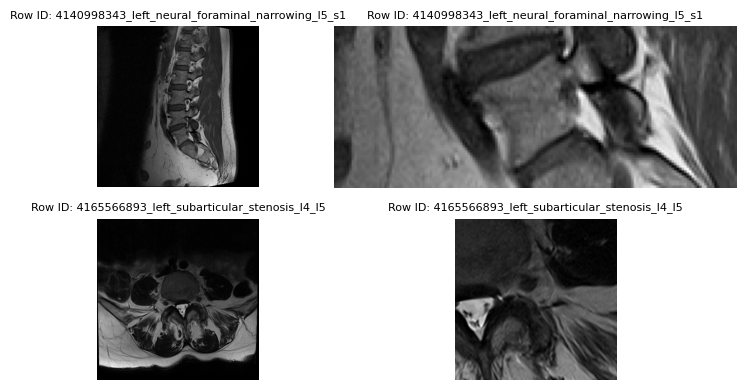

In [ ]:
import random
images = []
row_ids = []
selected_indices = random.sample(range(len(train_data)), 2)
for i in selected_indices:
    image_path=train_data['image_path'][i]
    base_path = "/content/drive/MyDrive/FYPDataset/rsna-2024-lumbar-spine-degenerative-classification//"
    relative_path = image_path.replace(base_path, "", 1)
    image = load_dicom(relative_path)
    cropped_image = load_dicom_cropped(relative_path, train_data['x'][i], train_data['y'][i], train_data['condition'][i])
    images.append(image)
    images.append(cropped_image)
    row_ids.append(train_data['row_id'][i])
    row_ids.append(train_data['row_id'][i])

# Plot images
fig, ax = plt.subplots(2, 2, figsize=(8, 4))

for i in range(4):
    row, col = divmod(i, 2)  # Convert i into (row, col) for subplot indexing
    ax[row, col].imshow(images[i], cmap='gray')
    ax[row, col].set_title(f'Row ID: {row_ids[i]}', fontsize=8)
    ax[row, col].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
train_data = train_data.dropna()

In [ ]:
import pandas as pd

# Mount Google Drive (if not already mounted)
from google.colab import drive
drive.mount('/content/drive')

# Define the base path in Google Drive
base_path = "/content/drive/MyDrive/FYPDataset/rsna-2024-lumbar-spine-degenerative-classification"

# Define the full file paths
train_csv_path = f"{base_path}/train_data.csv"
test_csv_path = f"{base_path}/test_data.csv"

# Save the DataFrames as CSV files in Google Drive
train_data.to_csv(train_csv_path, index=False)
test_data.to_csv(test_csv_path, index=False)



In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision.transforms import RandAugment
import torchvision.transforms as transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from PIL import Image
import torch
import numpy as np
import torch.optim.lr_scheduler as lr_scheduler
from tqdm import tqdm

import torchvision.transforms as transforms

# Modify dataset class to apply augmentations per class
class CustomDataset(Dataset):
    def __init__(self, dataframe,label_map,c):
        self.dataframe = dataframe
        self.check=c

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        image_path = self.dataframe['image_path'][index]
        base_path = "/content/drive/MyDrive/FYPDataset/rsna-2024-lumbar-spine-degenerative-classification//"
        relative_path = image_path.replace(base_path, "", 1)
        x = self.dataframe['x'][index]
        y = self.dataframe['y'][index]
        condition = self.dataframe['condition'][index]
        image = load_dicom_cropped(relative_path,x,y,condition)  # Define this function to load your DICOM images
        label = self.dataframe['severity_idx'][index]

        if self.check=='t':
            # Define the Albumentations augmentations
            albumentations_transform = A.Compose([
            A.RandomBrightnessContrast(p=0.25),  # Adjust brightness & contrast randomly
            A.ShiftScaleRotate(shift_limit=0.1, scale_limit=(-0.1, 0.1), rotate_limit=20, p=0.5)])  # Shift, Scale, Rotate

            # Convert tensor to NumPy array if needed
            if isinstance(image, torch.Tensor):
                image = image.numpy()

            # Convert grayscale image (H, W) to (H, W, C) for Albumentations
            if len(image.shape) == 2:
                image = np.expand_dims(image, axis=-1)

            # Apply Albumentations transforms (expects NumPy array)
            augmented = albumentations_transform(image=image)["image"]

            # Convert back to PIL image for Torchvision pipeline
            image = Image.fromarray(augmented.squeeze())

        else:
            image = Image.fromarray(image)

        # Apply Torchvision transforms
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.Grayscale(num_output_channels=3),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
       

        image = transform(image)

        return image, label

# Function to create datasets and dataloaders for each series description
def create_datasets_and_loaders(df, series_description, batch_size=32):
    filtered_df = df[df['series_description'] == series_description].reset_index(drop=True)

    # Check the frequency of each class in the 'severity' column
    class_counts = filtered_df['severity'].value_counts().to_dict()

    # Define label mapping globally
    unique_classes = sorted(class_counts.keys())  # Ensures consistent ordering
    label_map = {cls: i for i, cls in enumerate(unique_classes)}

    print(f"Class Frequencies in 'severity' column of: {series_description}")
    print(class_counts)

    # Convert class labels to numerical indices
    filtered_df['severity_idx'] = filtered_df['severity'].map(label_map)

    # Convert values to integer type explicitly
    filtered_df['severity_idx'] = filtered_df['severity_idx'].astype(int)
    print(filtered_df)

    # Create train/validation split
    train_df, val_df = train_test_split(filtered_df, test_size=0.2, random_state=42, stratify=filtered_df['severity'])

    train_df = train_df.reset_index(drop=True)
    val_df = val_df.reset_index(drop=True)


    # Create dataset objects
    train_dataset = CustomDataset(train_df, label_map,'t')
    val_dataset = CustomDataset(val_df, label_map,'v')

    # Create dataloaders
    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=2)
    valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    return trainloader, valloader, len(train_df), len(val_df)




# Create dataloaders for each series description
dataloaders = {}
lengths = {}

trainloader_t1, valloader_t1, len_train_t1, len_val_t1 = create_datasets_and_loaders(train_data, 'Sagittal T1')
trainloader_t2, valloader_t2, len_train_t2, len_val_t2 = create_datasets_and_loaders(train_data, 'Axial T2')
trainloader_t2stir, valloader_t2stir, len_train_t2stir, len_val_t2stir = create_datasets_and_loaders(train_data, 'Sagittal T2/STIR')

dataloaders['Sagittal T1'] = (trainloader_t1, valloader_t1)
dataloaders['Axial T2'] = (trainloader_t2, valloader_t2)
dataloaders['Sagittal T2/STIR'] = (trainloader_t2stir, valloader_t2stir)

lengths['Sagittal T1'] = (len_train_t1, len_val_t1)
lengths['Axial T2'] = (len_train_t2, len_val_t2)
lengths['Sagittal T2/STIR'] = (len_train_t2stir, len_val_t2stir)




Class Frequencies in 'severity' column of: Sagittal T1
{'normal_mild': 15358, 'moderate': 3560, 'severe': 776}
         study_id                         condition  level     severity  \
0         4003253   Left Neural Foraminal Narrowing  L1/L2  normal_mild   
1         4003253   Left Neural Foraminal Narrowing  L2/L3  normal_mild   
2         4003253   Left Neural Foraminal Narrowing  L3/L4  normal_mild   
3         4003253   Left Neural Foraminal Narrowing  L4/L5     moderate   
4         4003253   Left Neural Foraminal Narrowing  L5/S1  normal_mild   
...           ...                               ...    ...          ...   
19689  4290709089  Right Neural Foraminal Narrowing  L1/L2  normal_mild   
19690  4290709089  Right Neural Foraminal Narrowing  L2/L3  normal_mild   
19691  4290709089  Right Neural Foraminal Narrowing  L3/L4  normal_mild   
19692  4290709089  Right Neural Foraminal Narrowing  L4/L5  normal_mild   
19693  4290709089  Right Neural Foraminal Narrowing  L5/S1  norm

In [ ]:
class_frequencies = train_data['severity'].value_counts()

# Display the frequency of each class
print("And Class Frequencies in 'severity' column of : all train data")
print(class_frequencies)

And Class Frequencies in 'severity' column of : all train data
severity
normal_mild    37626
moderate        7950
severe          3081
Name: count, dtype: int64


Visualizing Sagittal T1 samples


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.980906..0.44392177].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..0.77507645].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.0996952].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..1.7685405].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8096584..1.3328106].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7754089..1.6639653].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904

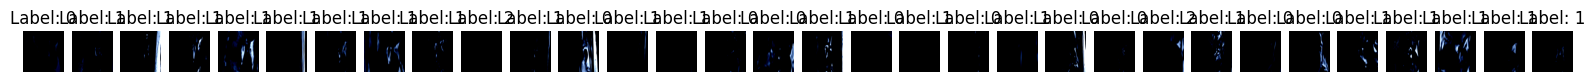

Visualizing Axial T2 samples


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.367669].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.6291069].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.5245317].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2216995].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.7511113].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.0822659].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.587

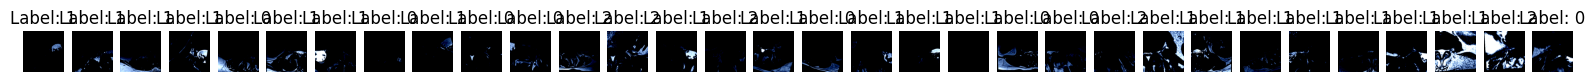

Visualizing Sagittal T2/STIR samples


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9466565..0.5484969].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.6988237].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.9951199].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.0474076].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.1585187].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3815396..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.8

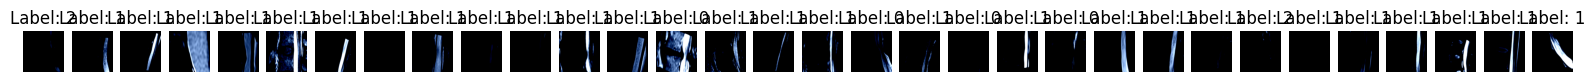

In [ ]:
import matplotlib.pyplot as plt

# Function to visualize a batch of images
def visualize_batch(dataloader):
    images, labels = next(iter(dataloader))
    fig, axes = plt.subplots(1, len(images), figsize=(20, 5))
    for i, (img, lbl) in enumerate(zip(images, labels)):
        ax = axes[i]
        img = img.permute(1, 2, 0)  # Convert to HWC for visualization
        ax.imshow(img)
        ax.set_title(f"Label: {lbl}")
        ax.axis('off')
    plt.show()

# Visualize samples from each dataloader
print("Visualizing Sagittal T1 samples")
visualize_batch(valloader_t1)
print("Visualizing Axial T2 samples")
visualize_batch(trainloader_t2)
print("Visualizing Sagittal T2/STIR samples")
visualize_batch(trainloader_t2stir)


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import pandas as pd
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler
from copy import deepcopy
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


class ClassBalancedFocalLoss(nn.Module):
    def __init__(self, class_counts, beta=0.99, gamma=2.0):
        super(ClassBalancedFocalLoss, self).__init__()

        # Compute effective class weights
        effective_num = 1.0 - torch.pow(beta, torch.tensor(class_counts, dtype=torch.float))
        self.class_weights = (1.0 - beta) / effective_num
        self.class_weights = self.class_weights / self.class_weights.sum()  # Normalize

        self.gamma = gamma

    def forward(self, logits, labels):
        # Convert labels to one-hot encoding
        labels_one_hot = F.one_hot(labels, num_classes=logits.shape[1]).float()

        # Compute softmax probabilities
        probs = torch.softmax(logits, dim=1)

        # Compute focal loss factor
        focal_factor = (1.0 - probs) ** self.gamma

        # Compute loss
        loss = -self.class_weights.to(logits.device) * focal_factor * labels_one_hot * torch.log(probs + 1e-8)
        return loss.sum(dim=1).mean()



# ---------------------------
#  CBAM Implementation
# ---------------------------
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc1 = nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        assert kernel_size in (3, 7), "Kernel size must be 3 or 7"
        padding = (kernel_size - 1) // 2
        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        out = torch.cat([avg_out, max_out], dim=1)
        out = self.conv1(out)
        return self.sigmoid(out)

class CBAM(nn.Module):
    def __init__(self, in_planes, ratio=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.ca = ChannelAttention(in_planes, ratio)
        self.sa = SpatialAttention(kernel_size)

    def forward(self, x):
        x = x * self.ca(x)
        x = x * self.sa(x)
        return x

# ---------------------------
#  CBAM + ConvNeXt Base Model
# ---------------------------
class CBAMConvNeXt(nn.Module):
    def __init__(self, num_classes=3, num_unfreeze_blocks=2):
        super(CBAMConvNeXt, self).__init__()
        # Load ConvNeXt Base model
        self.model = models.convnext_base(pretrained=True)

        # Extract features
        self.features = self.model.features

        # Add CBAM after the final feature extraction stage
        self.cbam = CBAM(in_planes=1024)  # ConvNeXt Base final feature size

        # Modify Classifier
        num_ftrs = self.model.classifier[2].in_features
        self.model.classifier = nn.Sequential(
            nn.LayerNorm(num_ftrs),
            nn.Flatten(),
            nn.Dropout(0.4),  # Dropout for regularization
            nn.Linear(num_ftrs, num_classes)
        )

        # Freeze all layers initially
        for param in self.features.parameters():
            param.requires_grad = False

        # Unfreeze layers using the internal function
        self.unfreeze_model(num_unfreeze_blocks)

    def forward(self, x):
        x = self.features(x)  # Feature extraction
        x = self.cbam(x)      # CBAM attention module
        x = x.mean([2, 3])    # Global Average Pooling
        x = self.model.classifier(x)  # Classifier
        return x

    def unfreeze_model(self, num_blocks=2):
        """
        Unfreezes CBAM, classifier, and the last `num_blocks` ConvNeXt layers.
        """
        # Unfreeze CBAM
        self.cbam.requires_grad_(True)

        # Unfreeze Classifier
        for param in self.model.classifier.parameters():
            param.requires_grad = True

        # Unfreeze the last `num_blocks` ConvNeXt blocks
        convnext_blocks = list(self.features.children())[-num_blocks:]
        for i, block in enumerate(convnext_blocks, start=1):
            for param in block.parameters():
                param.requires_grad = True



# Define the Custom DenseNet121 Model
class CustomDenseNet121(nn.Module):
    def __init__(self, num_classes=3):
        super(CustomDenseNet121, self).__init__()
        # Load DenseNet121 with pretrained ImageNet weights
        self.model = models.densenet121(pretrained=True)


        # Modify the classifier part of DenseNet
        num_ftrs = self.model.classifier.in_features
        self.model.classifier = nn.Linear(num_ftrs, num_classes)
       

    def forward(self, x):
        return self.model(x)

    def unfreeze_model(self):
        # Unfreeze the fully connected layers (classifier)
        for param in self.model.classifier.parameters():
            param.requires_grad = True

        # Unfreeze the last 10 convolutional layers in features
        layers = list(self.model.features.children())[-15:]
        for layer in layers:
            for param in layer.parameters():
                param.requires_grad = True


class CustomEfficientNetV2(nn.Module):
    def __init__(self, num_classes=3, pretrained_weights=None, device='cuda'):
        super(CustomEfficientNetV2, self).__init__()
        self.model = models.efficientnet_v2_s(weights=None)

        if pretrained_weights:
            if os.path.exists(pretrained_weights):
                try:
                    print(f"Loading pretrained weights from: {pretrained_weights}")
                    state_dict = torch.load(pretrained_weights, map_location=torch.device(device))
                    self.model.load_state_dict(state_dict)
                    print("Weights loaded successfully!")
                except Exception as e:
                    print(f"Error loading weights: {e}")
            else:
                print(f"Weights file not found at: {pretrained_weights}")

        num_ftrs = self.model.classifier[-1].in_features
        self.model.classifier[-1] = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.model(x)

    def unfreeze_model(self):
        # Unfreeze the last 20 layers, keeping BatchNorm layers frozen
        for layer in list(self.model.features.children())[-20:]:
            if not isinstance(layer, nn.BatchNorm2d):
                for param in layer.parameters():
                    param.requires_grad = True

        # Unfreeze the classifier
        for param in self.model.classifier.parameters():
            param.requires_grad = True


# Path to the locally uploaded weights file
weights_path = '/content/drive/MyDrive/FYPDataset/rsna-2024-lumbar-spine-degenerative-classification/weights.pth'


class CustomConvNeXt(nn.Module):
    def __init__(self, num_classes=3):
        super(CustomConvNeXt, self).__init__()

        # ✅ Load ConvNeXt Base Model (Pretrained)
        self.model = models.convnext_base(pretrained=True)

        # ✅ Modify Classifier
        num_ftrs = self.model.classifier[2].in_features
        self.model.classifier[2] = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.model(x)

    def unfreeze_model(self):
        # ✅ Unfreeze Fully Connected Layers
        for param in self.model.classifier.parameters():
            param.requires_grad = True

        # ✅ Unfreeze Last Few Convolutional Layers (Match DenseNet)
        layers = list(self.model.features.children())[-10:]
        for layer in layers:
            for param in layer.parameters():
                param.requires_grad = True


# Check for CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

#sagittal_t1_model = CustomConvNeXt(num_classes=3).to(device)
#axial_t2_model = CustomConvNeXt(num_classes=3).to(device)
#sagittal_t2stir_model = CustomConvNeXt(num_classes=3).to(device)

# Initialize models
#sagittal_t1_model = CustomEfficientNetV2(num_classes=3, pretrained_weights=weights_path).to(device)
#axial_t2_model = CustomEfficientNetV2(num_classes=3, pretrained_weights=weights_path).to(device)
#sagittal_t2stir_model = CustomEfficientNetV2(num_classes=3, pretrained_weights=weights_path).to(device)

# Initialize models with pretrained ImageNet weights
#sagittal_t1_model = CustomDenseNet121(num_classes=3).to(device)
#axial_t2_model = CustomDenseNet121(num_classes=3).to(device)
#sagittal_t2stir_model = CustomDenseNet121(num_classes=3).to(device)

#sagittal_t1_model = CustomEfficientNetV2(num_classes=3).to(device)
#axial_t2_model = CustomEfficientNetV2(num_classes=3).to(device)
#sagittal_t2stir_model = CustomEfficientNetV2(num_classes=3).to(device)

sagittal_t1_model = CBAMConvNeXt(num_classes=3, num_unfreeze_blocks=5).to(device)
axial_t2_model = CBAMConvNeXt(num_classes=3, num_unfreeze_blocks=5).to(device)
sagittal_t2stir_model = CBAMConvNeXt(num_classes=3, num_unfreeze_blocks=45).to(device)

#sagittal_t1_model = CBAMDenseNet121(num_classes=3, num_unfreeze_blocks=4).to(device)
#axial_t2_model = CBAMDenseNet121(num_classes=3, num_unfreeze_blocks=4).to(device)
#sagittal_t2stir_model = CBAMDenseNet121(num_classes=3, num_unfreeze_blocks=4).to(device)


# Freeze initial layers (features)
#for param in sagittal_t1_model.model.features.parameters():
#    param.requires_grad = False
#for param in axial_t2_model.model.features.parameters():
#    param.requires_grad = False
#for param in sagittal_t2stir_model.model.features.parameters():
#    param.requires_grad = False

# Unfreeze the final fully connected layer (classifier) and some convolutional layers
#sagittal_t1_model.cbam.requires_grad_(True)
#sagittal_t1_model.model.classifier.requires_grad_(True)
#axial_t2_model.cbam.requires_grad_(True)
#axial_t2_model.model.classifier.requires_grad_(True)
#sagittal_t2stir_model.cbam.requires_grad_(True)
#sagittal_t2stir_model.model.classifier.requires_grad_(True)

# Unfreeze the final fully connected layer (classifier) and some convolutional layers
#sagittal_t1_model.unfreeze_model()
#axial_t2_model.unfreeze_model()
#sagittal_t2stir_model.unfreeze_model()

# Define dummy Focal Loss
#total_counts = torch.tensor([37626, 7950, 3081], dtype=torch.float)
#general_alpha = (1 / total_counts)
#general_alpha = general_alpha / general_alpha.sum()
#general_alpha = general_alpha.to(device)
#print("General alpha values:", general_alpha)
#criterion = FocalLoss(gamma=2,alpha=general_alpha)
criterion=nn.CrossEntropyLoss()

# Initialize separate optimizers for each model
optimizer_sagittal_t1 = torch.optim.Adam(filter(lambda p: p.requires_grad, sagittal_t1_model.parameters()), lr=3e-5, weight_decay=1e-4)#, weight_decay=1e-4
optimizer_axial_t2 = torch.optim.Adam(filter(lambda p: p.requires_grad, axial_t2_model.parameters()), lr=3e-5, weight_decay=1e-4)
optimizer_sagittal_t2stir = torch.optim.Adam(filter(lambda p: p.requires_grad, sagittal_t2stir_model.parameters()), lr=3e-5, weight_decay=1e-4)

# Store the models and optimizers in dictionaries for easy access
models = {
    'Sagittal T1': sagittal_t1_model,
    'Axial T2': axial_t2_model,
    'Sagittal T2/STIR': sagittal_t2stir_model,
}
optimizers = {
    'Sagittal T1': optimizer_sagittal_t1,
    'Axial T2': optimizer_axial_t2,
    'Sagittal T2/STIR': optimizer_sagittal_t2stir,
}

Using device: cuda


In [ ]:
trainable_params = sum(p.numel() for p in sagittal_t1_model.parameters() if p.requires_grad)
print(f"Number of parameters: {trainable_params}")

Number of parameters: 87147109


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="albumentations")

In [ ]:
for images, labels in trainloader_t2:
    labels = labels.to(device)  # Directly send to device (they're already numeric)
    print(labels)
    break


tensor([0, 1, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 2,
        1, 1, 0, 1, 1, 1, 0, 2], device='cuda:0')


In [ ]:
import torch
import torch.optim.lr_scheduler as lr_scheduler
from copy import deepcopy
from tqdm import tqdm
from sklearn.preprocessing import label_binarize

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


def train_model(model, trainloader, valloader, len_train, len_val, optimizer, num_epochs=20, patience=5):
    # Learning rate scheduler
    #scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=2, factor=0.3, verbose=True)
    scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=1e-4, steps_per_epoch=len(trainloader), epochs=num_epochs, pct_start=0.3, anneal_strategy='linear')
    #scheduler = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

    best_val_f1 = 0.0
    best_model_wts = deepcopy(model.state_dict())
    counter = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct_train = 0
        train_preds, train_labels = [], []

        with tqdm(trainloader, unit="batch") as tepoch:
            for images, labels in tepoch:
                images, labels = images.to(device), labels.to(device)  
                optimizer.zero_grad()
                outputs = model(images)

                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                scheduler.step()
                train_loss += loss.item()

                probabilities = torch.softmax(outputs, dim=1)
                _, predicted = torch.max(probabilities, 1)
                correct_train += (predicted == labels).sum().item()

                # Store predictions and true labels for additional metrics
                train_preds.extend(predicted.cpu().numpy())
                train_labels.extend(labels.cpu().numpy())

                tepoch.set_postfix(epoch=epoch+1)

        #scheduler.step()

        train_loss /= len(trainloader)
        train_acc = 100 * correct_train / len_train
        train_precision = precision_score(train_labels, train_preds, average='macro', zero_division=0)
        train_recall = recall_score(train_labels, train_preds, average='macro', zero_division=0)
        train_f1 = f1_score(train_labels, train_preds, average='macro', zero_division=0)

        model.eval()
        val_loss, correct_val = 0, 0
        val_preds, val_labels = [], []

        with torch.no_grad():
            with tqdm(valloader, unit="batch") as vepoch:
                for images, labels in vepoch:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()

                    probabilities = torch.softmax(outputs, dim=1).squeeze(0)
                    _, predicted = torch.max(probabilities, 1)
                    correct_val += (predicted == labels).sum().item()

                    # Store predictions and true labels for additional metrics
                    val_preds.extend(predicted.cpu().numpy())
                    val_labels.extend(labels.cpu().numpy())

                    vepoch.set_postfix(epoch=epoch+1)

        val_loss /= len(valloader)
        val_acc = 100 * correct_val / len_val
        val_precision = precision_score(val_labels, val_preds, average='macro', zero_division=0)
        val_recall = recall_score(val_labels, val_preds, average='macro', zero_division=0)
        val_f1 = f1_score(val_labels, val_preds, average='macro', zero_division=0)
        

        print(f"Epoch {epoch+1}:")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}, Train F1: {train_f1:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}, Val F1: {val_f1:.4f}","\n" ) #, Val AUC-ROC: {val_auc:.4f}
        #print(val_labels,"\n", val_preds,"\n")

        # Reduce LR dynamically based on validation loss
        #scheduler.step(val_f1)

        # Save the best model and check for early stopping
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_model_wts = deepcopy(model.state_dict())
            counter = 0
            torch.save(best_model_wts, f'best_model_epoch{epoch+1}.pth')
        else:
            counter += 1

        # Early stopping
        if counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs\n")
            break

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, best_val_f1

In [ ]:
# Define class counts from dataset (example counts)
class_counts_t1 = [15358, 3560, 776]  # For Sagittal T1
class_counts_t2 = [13719, 3659, 1837]  # For Axial T2
class_counts_t2stir = [8549, 731, 468]  # For Sagittal T2/STIR

# Initialize CB Focal Loss with different class distributions
criterion_t1 = ClassBalancedFocalLoss(class_counts_t1, beta=0.99, gamma=3)
criterion_t2 = ClassBalancedFocalLoss(class_counts_t2, beta=0.99, gamma=3)
criterion_t2stir = ClassBalancedFocalLoss(class_counts_t2stir, beta=0.99, gamma=3)


##ConvNeXt with CBAM(Convolutional Block Attention Modeule)

In [ ]:
# Training all models
for desc, model in models.items():
    if desc == 'Sagittal T1':
        criterion = criterion_t1
        trainloader, valloader, len_train, len_val = trainloader_t1, valloader_t1, len_train_t1, len_val_t1
    elif desc == 'Axial T2':
        criterion = criterion_t2
        trainloader, valloader, len_train, len_val = trainloader_t2, valloader_t2, len_train_t2, len_val_t2
    elif desc == 'Sagittal T2/STIR':
        criterion = criterion_t2stir
        trainloader, valloader, len_train, len_val = trainloader_t2stir, valloader_t2stir, len_train_t2stir, len_val_t2stir

    print(f"Training model for {desc}")
    train_model(model, trainloader, valloader, len_train, len_val, optimizers[desc])

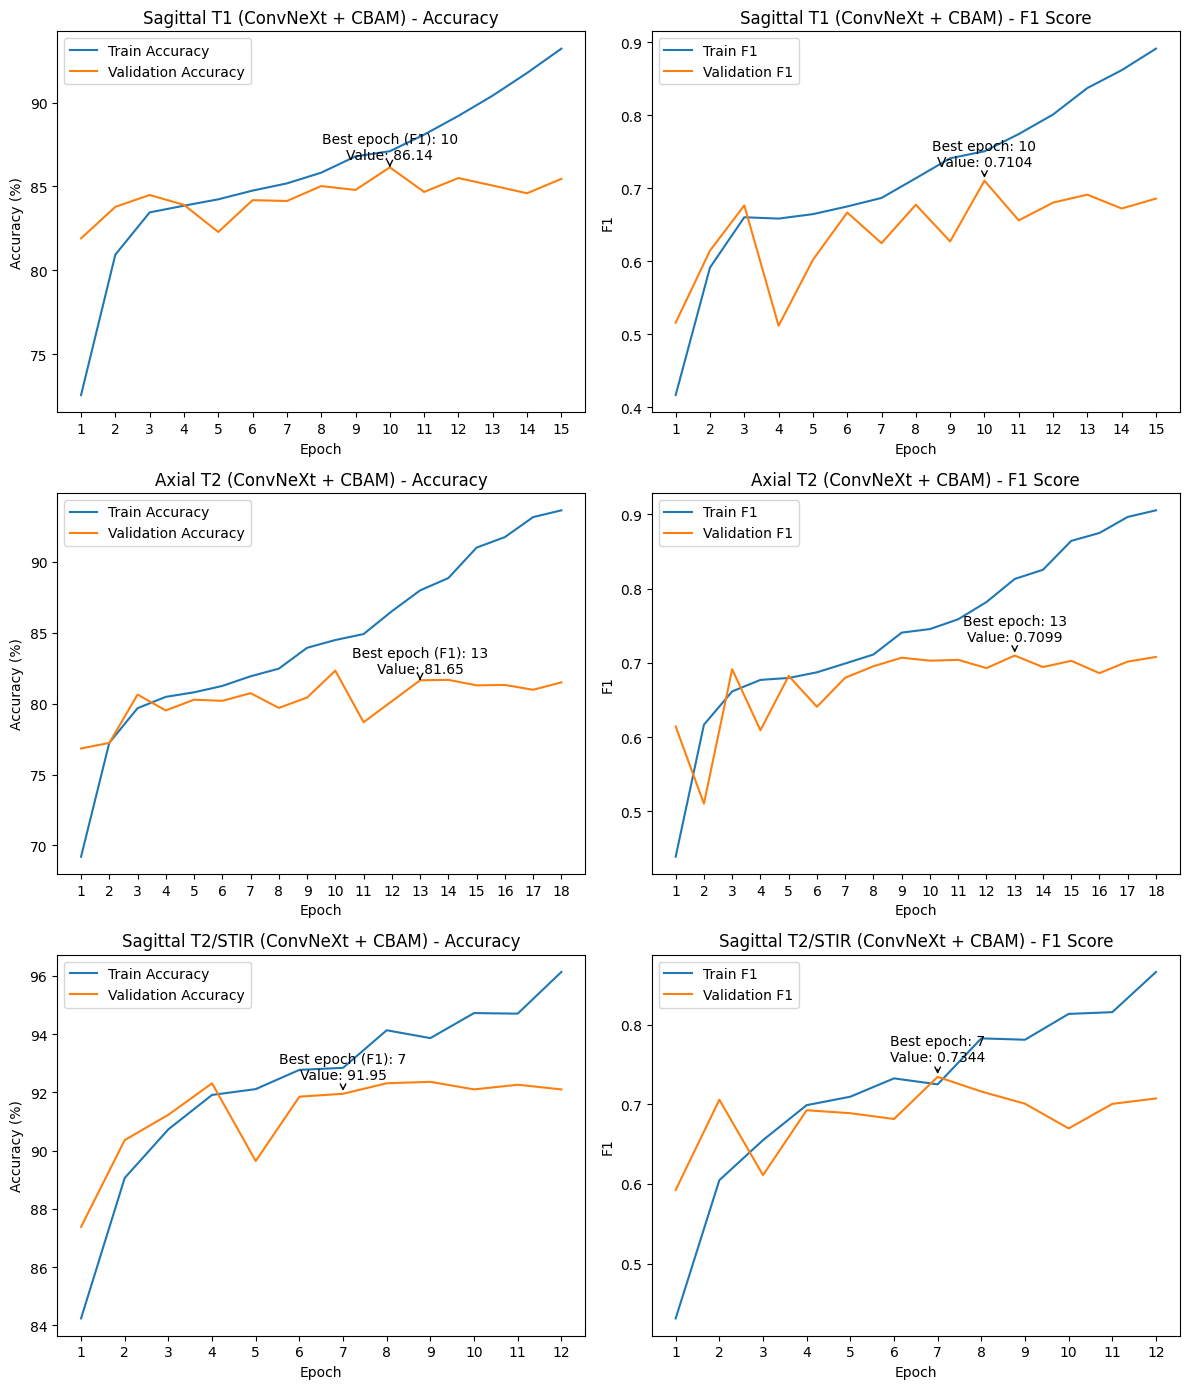

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 1) DATA DEFINITION
#    (All values transcribed from your ConvNeXt + CBAM logs)
# ------------------------------------------------------------

# A) Sagittal T1 (15 epochs)
cbam_t1_train_acc = [
    72.55, 80.93, 83.45, 83.85, 84.23,
    84.75, 85.18, 85.82, 86.79, 87.10,
    88.09, 89.21, 90.42, 91.77, 93.22
]
cbam_t1_val_acc = [
    81.90, 83.78, 84.49, 83.90, 82.28,
    84.18, 84.13, 85.02, 84.79, 86.14,
    84.67, 85.50, 85.05, 84.59, 85.45
]
cbam_t1_train_f1 = [
    0.4164, 0.5912, 0.6602, 0.6584, 0.6645,
    0.6750, 0.6867, 0.7137, 0.7411, 0.7507,
    0.7743, 0.8011, 0.8374, 0.8619, 0.8914
]
cbam_t1_val_f1 = [
    0.5157, 0.6144, 0.6765, 0.5115, 0.6018,
    0.6667, 0.6247, 0.6774, 0.6271, 0.7104,
    0.6559, 0.6803, 0.6912, 0.6722, 0.6858
]

# B) Axial T2 (18 epochs)
cbam_ax_t2_train_acc = [
    69.20, 77.24, 79.68, 80.48, 80.80,
    81.25, 81.93, 82.47, 83.94, 84.49,
    84.91, 86.52, 87.99, 88.86, 91.01,
    91.75, 93.16, 93.64
]
cbam_ax_t2_val_acc = [
    76.84, 77.23, 80.64, 79.52, 80.28,
    80.20, 80.74, 79.70, 80.43, 82.33,
    78.69, 80.17, 81.65, 81.68, 81.29,
    81.32, 80.98, 81.50
]
cbam_ax_t2_train_f1 = [
    0.4388, 0.6167, 0.6616, 0.6771, 0.6797,
    0.6873, 0.6992, 0.7113, 0.7408, 0.7456,
    0.7588, 0.7820, 0.8131, 0.8255, 0.8644,
    0.8751, 0.8967, 0.9056
]
cbam_ax_t2_val_f1 = [
    0.6143, 0.5103, 0.6915, 0.6092, 0.6824,
    0.6409, 0.6800, 0.6955, 0.7070, 0.7030,
    0.7041, 0.6930, 0.7099, 0.6944, 0.7028,
    0.6862, 0.7018, 0.7080
]

# C) Sagittal T2/STIR (12 epochs)
cbam_t2stir_train_acc = [
    84.24, 89.06, 90.73, 91.91, 92.11,
    92.77, 92.84, 94.13, 93.86, 94.72,
    94.70, 96.13
]
cbam_t2stir_val_acc = [
    87.38, 90.36, 91.23, 92.31, 89.64,
    91.85, 91.95, 92.31, 92.36, 92.10,
    92.26, 92.10
]
cbam_t2stir_train_f1 = [
    0.4313, 0.6047, 0.6550, 0.6989, 0.7095,
    0.7325, 0.7250, 0.7827, 0.7810, 0.8134,
    0.8156, 0.8660
]
cbam_t2stir_val_f1 = [
    0.5924, 0.7057, 0.6111, 0.6925, 0.6888,
    0.6815, 0.7344, 0.7160, 0.7007, 0.6697,
    0.7005, 0.7073
]

# ------------------------------------------------------------
# 2) UTILITY: FUNCTION TO PLOT A SINGLE MODEL (2 subplots)
# ------------------------------------------------------------
def plot_model(ax_acc, ax_f1, train_acc, val_acc, train_f1, val_f1, title_str):
    """
    ax_acc, ax_f1 : matplotlib Axes objects for accuracy and f1 subplots
    train_acc, val_acc, train_f1, val_f1 : lists of metric values
    title_str : for labeling this model's row
    """

    epochs = np.arange(1, len(train_acc)+1)

    # ---- Accuracy subplot ----
    ax_acc.plot(epochs, train_acc, label='Train Accuracy')
    ax_acc.plot(epochs, val_acc, label='Validation Accuracy')
    ax_acc.set_title(f'{title_str} - Accuracy')
    ax_acc.set_xlabel('Epoch')
    ax_acc.set_ylabel('Accuracy (%)')
    ax_acc.set_xticks(epochs)
    ax_acc.legend(loc='best')

    # Find best epoch (highest val_f1)
    best_epoch_f1 = np.argmax(val_f1)
    best_epoch_f1_number = best_epoch_f1 + 1  # +1 because epochs are 1-indexed
    best_acc_at_f1 = val_acc[best_epoch_f1]   # validation ACC at that best-F1 epoch
    # Annotate on the accuracy subplot
    text_str_acc = f'Best epoch (F1): {best_epoch_f1_number}\nValue: {best_acc_at_f1:.2f}'
    ax_acc.annotate(
        text_str_acc,
        xy=(best_epoch_f1_number, best_acc_at_f1),
        xytext=(best_epoch_f1_number, best_acc_at_f1 + 0.5),
        arrowprops=dict(arrowstyle='->', color='black'),
        ha='center'
    )

    # ---- F1 subplot ----
    ax_f1.plot(epochs, train_f1, label='Train F1')
    ax_f1.plot(epochs, val_f1, label='Validation F1')
    ax_f1.set_title(f'{title_str} - F1 Score')
    ax_f1.set_xlabel('Epoch')
    ax_f1.set_ylabel('F1')
    ax_f1.set_xticks(epochs)
    ax_f1.legend(loc='best')

    # Highest val_f1:
    best_val_f1 = val_f1[best_epoch_f1]
    text_str_f1 = f'Best epoch: {best_epoch_f1_number}\nValue: {best_val_f1:.4f}'
    ax_f1.annotate(
        text_str_f1,
        xy=(best_epoch_f1_number, best_val_f1),
        xytext=(best_epoch_f1_number, best_val_f1 + 0.02),
        arrowprops=dict(arrowstyle='->', color='black'),
        ha='center'
    )

# ------------------------------------------------------------
# 3) MAIN PLOTTING
# ------------------------------------------------------------
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 14))

# Row 1: Sagittal T1 (ConvNeXt + CBAM)
plot_model(
    axes[0,0],
    axes[0,1],
    cbam_t1_train_acc,
    cbam_t1_val_acc,
    cbam_t1_train_f1,
    cbam_t1_val_f1,
    "Sagittal T1 (ConvNeXt + CBAM)"
)

# Row 2: Axial T2 (ConvNeXt + CBAM)
plot_model(
    axes[1,0],
    axes[1,1],
    cbam_ax_t2_train_acc,
    cbam_ax_t2_val_acc,
    cbam_ax_t2_train_f1,
    cbam_ax_t2_val_f1,
    "Axial T2 (ConvNeXt + CBAM)"
)

# Row 3: Sagittal T2/STIR (ConvNeXt + CBAM)
plot_model(
    axes[2,0],
    axes[2,1],
    cbam_t2stir_train_acc,
    cbam_t2stir_val_acc,
    cbam_t2stir_train_f1,
    cbam_t2stir_val_f1,
    "Sagittal T2/STIR (ConvNeXt + CBAM)"
)

plt.tight_layout()
plt.show()


##ConvNeXt

In [ ]:
# Training all models
for desc, model in models.items():
    if desc == 'Sagittal T1':
        criterion = criterion_t1
        trainloader, valloader, len_train, len_val = trainloader_t1, valloader_t1, len_train_t1, len_val_t1
    elif desc == 'Axial T2':
        criterion = criterion_t2
        trainloader, valloader, len_train, len_val = trainloader_t2, valloader_t2, len_train_t2, len_val_t2
    elif desc == 'Sagittal T2/STIR':
        criterion = criterion_t2stir
        trainloader, valloader, len_train, len_val = trainloader_t2stir, valloader_t2stir, len_train_t2stir, len_val_t2stir

    print(f"Training model for {desc}")
    train_model(model, trainloader, valloader, len_train, len_val, optimizers[desc])

Training model for Sagittal T1


100%|██████████| 124/124 [03:38<00:00,  1.76s/batch, epoch=1]


Epoch 1:
Train Loss: 0.0364, Train Acc: 80.19%, Train Precision: 0.6002, Train Recall: 0.5012, Train F1: 0.5325
Val Loss: 0.0344, Val Acc: 82.76%, Val Precision: 0.6957, Val Recall: 0.5230, Val F1: 0.5645 



100%|██████████| 124/124 [00:32<00:00,  3.84batch/s, epoch=2]


Epoch 2:
Train Loss: 0.0287, Train Acc: 82.85%, Train Precision: 0.6590, Train Recall: 0.5859, Train F1: 0.6152
Val Loss: 0.0288, Val Acc: 82.86%, Val Precision: 0.4753, Val Recall: 0.4880, Val F1: 0.4814 



100%|██████████| 124/124 [00:32<00:00,  3.85batch/s, epoch=3]


Epoch 3:
Train Loss: 0.0288, Train Acc: 82.15%, Train Precision: 0.6448, Train Recall: 0.5757, Train F1: 0.6035
Val Loss: 0.0269, Val Acc: 83.73%, Val Precision: 0.8008, Val Recall: 0.5118, Val F1: 0.5403 



100%|██████████| 124/124 [00:32<00:00,  3.83batch/s, epoch=4]


Epoch 4:
Train Loss: 0.0293, Train Acc: 82.44%, Train Precision: 0.6363, Train Recall: 0.5631, Train F1: 0.5916
Val Loss: 0.0351, Val Acc: 82.41%, Val Precision: 0.7443, Val Recall: 0.5875, Val F1: 0.6190 



100%|██████████| 124/124 [00:32<00:00,  3.87batch/s, epoch=5]


Epoch 5:
Train Loss: 0.0301, Train Acc: 82.74%, Train Precision: 0.6560, Train Recall: 0.5756, Train F1: 0.6069
Val Loss: 0.0283, Val Acc: 81.90%, Val Precision: 0.6452, Val Recall: 0.6691, Val F1: 0.6560 



100%|██████████| 124/124 [00:32<00:00,  3.84batch/s, epoch=6]


Epoch 6:
Train Loss: 0.0293, Train Acc: 82.64%, Train Precision: 0.6586, Train Recall: 0.5790, Train F1: 0.6103
Val Loss: 0.0280, Val Acc: 82.13%, Val Precision: 0.6584, Val Recall: 0.6479, Val F1: 0.6505 



100%|██████████| 124/124 [00:32<00:00,  3.86batch/s, epoch=7]


Epoch 7:
Train Loss: 0.0282, Train Acc: 82.91%, Train Precision: 0.6722, Train Recall: 0.5886, Train F1: 0.6214
Val Loss: 0.0253, Val Acc: 83.32%, Val Precision: 0.6773, Val Recall: 0.6280, Val F1: 0.6486 



100%|██████████| 124/124 [00:31<00:00,  3.88batch/s, epoch=8]


Epoch 8:
Train Loss: 0.0278, Train Acc: 83.14%, Train Precision: 0.6587, Train Recall: 0.5798, Train F1: 0.6107
Val Loss: 0.0318, Val Acc: 83.63%, Val Precision: 0.8181, Val Recall: 0.4945, Val F1: 0.4982 



100%|██████████| 124/124 [00:32<00:00,  3.85batch/s, epoch=9]


Epoch 9:
Train Loss: 0.0250, Train Acc: 83.62%, Train Precision: 0.6882, Train Recall: 0.6057, Train F1: 0.6387
Val Loss: 0.0239, Val Acc: 84.06%, Val Precision: 0.6972, Val Recall: 0.6515, Val F1: 0.6717 



100%|██████████| 124/124 [00:31<00:00,  3.88batch/s, epoch=10]


Epoch 10:
Train Loss: 0.0238, Train Acc: 84.59%, Train Precision: 0.7137, Train Recall: 0.6463, Train F1: 0.6750
Val Loss: 0.0255, Val Acc: 85.05%, Val Precision: 0.7836, Val Recall: 0.5522, Val F1: 0.6077 



100%|██████████| 124/124 [00:32<00:00,  3.85batch/s, epoch=11]


Epoch 11:
Train Loss: 0.0232, Train Acc: 84.82%, Train Precision: 0.7153, Train Recall: 0.6492, Train F1: 0.6773
Val Loss: 0.0253, Val Acc: 83.88%, Val Precision: 0.6728, Val Recall: 0.6988, Val F1: 0.6830 



100%|██████████| 124/124 [00:32<00:00,  3.84batch/s, epoch=12]


Epoch 12:
Train Loss: 0.0219, Train Acc: 85.26%, Train Precision: 0.7229, Train Recall: 0.6722, Train F1: 0.6939
Val Loss: 0.0237, Val Acc: 84.56%, Val Precision: 0.7056, Val Recall: 0.6184, Val F1: 0.6441 



100%|██████████| 124/124 [00:31<00:00,  3.88batch/s, epoch=13]


Epoch 13:
Train Loss: 0.0202, Train Acc: 85.41%, Train Precision: 0.7314, Train Recall: 0.6834, Train F1: 0.7040
Val Loss: 0.0234, Val Acc: 84.34%, Val Precision: 0.6998, Val Recall: 0.6342, Val F1: 0.6415 



100%|██████████| 124/124 [00:31<00:00,  3.88batch/s, epoch=14]


Epoch 14:
Train Loss: 0.0190, Train Acc: 86.07%, Train Precision: 0.7460, Train Recall: 0.7004, Train F1: 0.7202
Val Loss: 0.0213, Val Acc: 85.38%, Val Precision: 0.7220, Val Recall: 0.6588, Val F1: 0.6855 



100%|██████████| 124/124 [00:31<00:00,  3.89batch/s, epoch=15]


Epoch 15:
Train Loss: 0.0171, Train Acc: 87.38%, Train Precision: 0.7784, Train Recall: 0.7342, Train F1: 0.7531
Val Loss: 0.0226, Val Acc: 85.48%, Val Precision: 0.7058, Val Recall: 0.6568, Val F1: 0.6722 



100%|██████████| 124/124 [00:31<00:00,  3.89batch/s, epoch=16]


Epoch 16:
Train Loss: 0.0155, Train Acc: 87.65%, Train Precision: 0.7864, Train Recall: 0.7483, Train F1: 0.7652
Val Loss: 0.0224, Val Acc: 84.11%, Val Precision: 0.6893, Val Recall: 0.7019, Val F1: 0.6954 



100%|██████████| 124/124 [00:32<00:00,  3.83batch/s, epoch=17]


Epoch 17:
Train Loss: 0.0135, Train Acc: 88.39%, Train Precision: 0.7983, Train Recall: 0.7704, Train F1: 0.7816
Val Loss: 0.0244, Val Acc: 85.45%, Val Precision: 0.7062, Val Recall: 0.6797, Val F1: 0.6875 



100%|██████████| 124/124 [00:32<00:00,  3.82batch/s, epoch=18]


Epoch 18:
Train Loss: 0.0126, Train Acc: 89.33%, Train Precision: 0.8190, Train Recall: 0.7982, Train F1: 0.8061
Val Loss: 0.0244, Val Acc: 85.63%, Val Precision: 0.7200, Val Recall: 0.6759, Val F1: 0.6949 



100%|██████████| 124/124 [00:31<00:00,  3.88batch/s, epoch=19]


Epoch 19:
Train Loss: 0.0118, Train Acc: 89.64%, Train Precision: 0.8319, Train Recall: 0.8023, Train F1: 0.8147
Val Loss: 0.0228, Val Acc: 85.63%, Val Precision: 0.7032, Val Recall: 0.6652, Val F1: 0.6819 



100%|██████████| 124/124 [00:31<00:00,  3.88batch/s, epoch=20]


Epoch 20:
Train Loss: 0.0118, Train Acc: 89.95%, Train Precision: 0.8444, Train Recall: 0.8150, Train F1: 0.8268
Val Loss: 0.0244, Val Acc: 85.45%, Val Precision: 0.7070, Val Recall: 0.6722, Val F1: 0.6876 

Training model for Axial T2


100%|██████████| 121/121 [08:00<00:00,  3.97s/batch, epoch=1]


Epoch 1:
Train Loss: 0.0458, Train Acc: 76.28%, Train Precision: 0.6176, Train Recall: 0.5646, Train F1: 0.5855
Val Loss: 0.0387, Val Acc: 79.44%, Val Precision: 0.6466, Val Recall: 0.6866, Val F1: 0.6507 



100%|██████████| 121/121 [00:27<00:00,  4.34batch/s, epoch=2]


Epoch 2:
Train Loss: 0.0368, Train Acc: 79.79%, Train Precision: 0.6782, Train Recall: 0.6477, Train F1: 0.6615
Val Loss: 0.0506, Val Acc: 71.30%, Val Precision: 0.6245, Val Recall: 0.7132, Val F1: 0.6455 



100%|██████████| 121/121 [00:27<00:00,  4.37batch/s, epoch=3]


Epoch 3:
Train Loss: 0.0384, Train Acc: 78.76%, Train Precision: 0.6546, Train Recall: 0.6235, Train F1: 0.6372
Val Loss: 0.0432, Val Acc: 78.77%, Val Precision: 0.7100, Val Recall: 0.5482, Val F1: 0.5903 



100%|██████████| 121/121 [00:27<00:00,  4.38batch/s, epoch=4]


Epoch 4:
Train Loss: 0.0371, Train Acc: 79.25%, Train Precision: 0.6662, Train Recall: 0.6404, Train F1: 0.6520
Val Loss: 0.0393, Val Acc: 78.48%, Val Precision: 0.6917, Val Recall: 0.7022, Val F1: 0.6904 



100%|██████████| 121/121 [00:27<00:00,  4.38batch/s, epoch=5]


Epoch 5:
Train Loss: 0.0371, Train Acc: 79.80%, Train Precision: 0.6734, Train Recall: 0.6462, Train F1: 0.6586
Val Loss: 0.0419, Val Acc: 76.50%, Val Precision: 0.6154, Val Recall: 0.6956, Val F1: 0.6405 



100%|██████████| 121/121 [00:28<00:00,  4.28batch/s, epoch=6]


Epoch 6:
Train Loss: 0.0367, Train Acc: 79.83%, Train Precision: 0.6729, Train Recall: 0.6443, Train F1: 0.6571
Val Loss: 0.0359, Val Acc: 79.63%, Val Precision: 0.6890, Val Recall: 0.6572, Val F1: 0.6713 



100%|██████████| 121/121 [00:27<00:00,  4.33batch/s, epoch=7]


Epoch 7:
Train Loss: 0.0354, Train Acc: 80.10%, Train Precision: 0.6799, Train Recall: 0.6558, Train F1: 0.6667
Val Loss: 0.0345, Val Acc: 80.04%, Val Precision: 0.7025, Val Recall: 0.6628, Val F1: 0.6803 



100%|██████████| 121/121 [00:27<00:00,  4.36batch/s, epoch=8]


Epoch 8:
Train Loss: 0.0344, Train Acc: 80.31%, Train Precision: 0.6805, Train Recall: 0.6594, Train F1: 0.6690
Val Loss: 0.0368, Val Acc: 78.30%, Val Precision: 0.6554, Val Recall: 0.7243, Val F1: 0.6822 



100%|██████████| 121/121 [00:27<00:00,  4.39batch/s, epoch=9]


Epoch 9:
Train Loss: 0.0327, Train Acc: 81.15%, Train Precision: 0.7030, Train Recall: 0.6808, Train F1: 0.6909
Val Loss: 0.0471, Val Acc: 77.91%, Val Precision: 0.6904, Val Recall: 0.5290, Val F1: 0.5696 

Early stopping triggered after 9 epochs

Training model for Sagittal T2/STIR


100%|██████████| 61/61 [00:32<00:00,  1.86batch/s, epoch=1]


Epoch 1:
Train Loss: 0.0275, Train Acc: 88.91%, Train Precision: 0.6042, Train Recall: 0.4992, Train F1: 0.5345
Val Loss: 0.0192, Val Acc: 90.26%, Val Precision: 0.6688, Val Recall: 0.7531, Val F1: 0.7044 



100%|██████████| 61/61 [00:15<00:00,  3.87batch/s, epoch=2]


Epoch 2:
Train Loss: 0.0198, Train Acc: 90.68%, Train Precision: 0.6536, Train Recall: 0.6102, Train F1: 0.6293
Val Loss: 0.0156, Val Acc: 92.10%, Val Precision: 0.7353, Val Recall: 0.6549, Val F1: 0.6583 



100%|██████████| 61/61 [00:15<00:00,  3.95batch/s, epoch=3]


Epoch 3:
Train Loss: 0.0195, Train Acc: 91.22%, Train Precision: 0.6867, Train Recall: 0.6321, Train F1: 0.6542
Val Loss: 0.0189, Val Acc: 90.00%, Val Precision: 0.7413, Val Recall: 0.6753, Val F1: 0.6501 



100%|██████████| 61/61 [00:15<00:00,  3.94batch/s, epoch=4]


Epoch 4:
Train Loss: 0.0211, Train Acc: 90.51%, Train Precision: 0.6571, Train Recall: 0.6015, Train F1: 0.6221
Val Loss: 0.0202, Val Acc: 91.13%, Val Precision: 0.7315, Val Recall: 0.5669, Val F1: 0.6209 



100%|██████████| 61/61 [00:15<00:00,  3.86batch/s, epoch=5]


Epoch 5:
Train Loss: 0.0210, Train Acc: 90.48%, Train Precision: 0.6511, Train Recall: 0.6097, Train F1: 0.6270
Val Loss: 0.0346, Val Acc: 83.49%, Val Precision: 0.5559, Val Recall: 0.7459, Val F1: 0.6086 



100%|██████████| 61/61 [00:15<00:00,  3.95batch/s, epoch=6]

Epoch 6:
Train Loss: 0.0215, Train Acc: 90.90%, Train Precision: 0.7012, Train Recall: 0.6076, Train F1: 0.6418
Val Loss: 0.0188, Val Acc: 90.77%, Val Precision: 0.6528, Val Recall: 0.6221, Val F1: 0.6197 

Early stopping triggered after 6 epochs



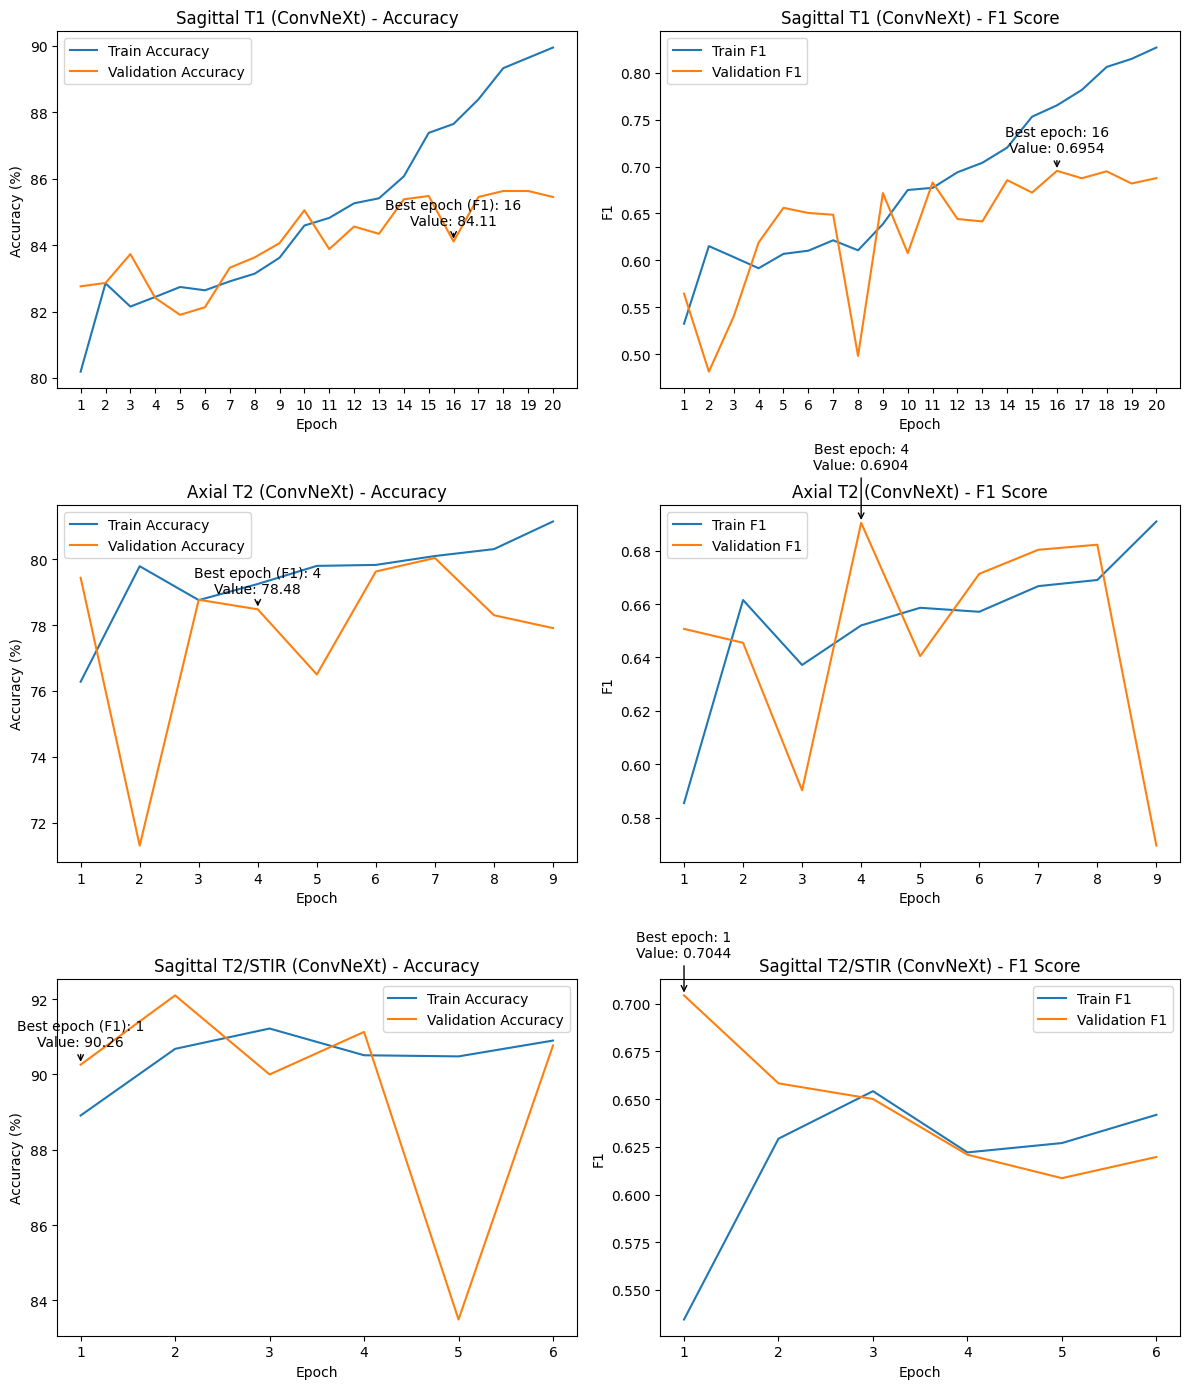

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 1) DATA DEFINITION
#    (All values transcribed from your ConvNeXt Base logs)
# ------------------------------------------------------------

# A) Sagittal T1 (20 epochs)
conv_t1_train_acc = [
    80.19, 82.85, 82.15, 82.44, 82.74,
    82.64, 82.91, 83.14, 83.62, 84.59,
    84.82, 85.26, 85.41, 86.07, 87.38,
    87.65, 88.39, 89.33, 89.64, 89.95
]
conv_t1_val_acc = [
    82.76, 82.86, 83.73, 82.41, 81.90,
    82.13, 83.32, 83.63, 84.06, 85.05,
    83.88, 84.56, 84.34, 85.38, 85.48,
    84.11, 85.45, 85.63, 85.63, 85.45
]
conv_t1_train_f1 = [
    0.5325, 0.6152, 0.6035, 0.5916, 0.6069,
    0.6103, 0.6214, 0.6107, 0.6387, 0.6750,
    0.6773, 0.6939, 0.7040, 0.7202, 0.7531,
    0.7652, 0.7816, 0.8061, 0.8147, 0.8268
]
conv_t1_val_f1 = [
    0.5645, 0.4814, 0.5403, 0.6190, 0.6560,
    0.6505, 0.6486, 0.4982, 0.6717, 0.6077,
    0.6830, 0.6441, 0.6415, 0.6855, 0.6722,
    0.6954, 0.6875, 0.6949, 0.6819, 0.6876
]

# B) Axial T2 (9 epochs)
conv_ax_t2_train_acc = [
    76.28, 79.79, 78.76, 79.25, 79.80,
    79.83, 80.10, 80.31, 81.15
]
conv_ax_t2_val_acc = [
    79.44, 71.30, 78.77, 78.48, 76.50,
    79.63, 80.04, 78.30, 77.91
]
conv_ax_t2_train_f1 = [
    0.5855, 0.6615, 0.6372, 0.6520, 0.6586,
    0.6571, 0.6667, 0.6690, 0.6909
]
conv_ax_t2_val_f1 = [
    0.6507, 0.6455, 0.5903, 0.6904, 0.6405,
    0.6713, 0.6803, 0.6822, 0.5696
]

# C) Sagittal T2/STIR (6 epochs)
conv_t2stir_train_acc = [
    88.91, 90.68, 91.22, 90.51, 90.48, 90.90
]
conv_t2stir_val_acc = [
    90.26, 92.10, 90.00, 91.13, 83.49, 90.77
]
conv_t2stir_train_f1 = [
    0.5345, 0.6293, 0.6542, 0.6221, 0.6270, 0.6418
]
conv_t2stir_val_f1 = [
    0.7044, 0.6583, 0.6501, 0.6209, 0.6086, 0.6197
]

# ------------------------------------------------------------
# 2) UTILITY: FUNCTION TO PLOT A SINGLE MODEL (2 subplots)
# ------------------------------------------------------------
def plot_model(ax_acc, ax_f1, train_acc, val_acc, train_f1, val_f1, title_str):
    """
    ax_acc, ax_f1 : matplotlib Axes objects for accuracy and f1 subplots
    train_acc, val_acc, train_f1, val_f1 : lists of metric values
    title_str : for labeling this model's row
    """

    epochs = np.arange(1, len(train_acc)+1)

    # ---- Accuracy subplot ----
    ax_acc.plot(epochs, train_acc, label='Train Accuracy')
    ax_acc.plot(epochs, val_acc, label='Validation Accuracy')
    ax_acc.set_title(f'{title_str} - Accuracy')
    ax_acc.set_xlabel('Epoch')
    ax_acc.set_ylabel('Accuracy (%)')
    ax_acc.set_xticks(epochs)
    ax_acc.legend(loc='best')

    # Find best epoch (highest val_f1)
    best_epoch_f1 = np.argmax(val_f1)
    best_epoch_f1_number = best_epoch_f1 + 1  # +1 because epochs are 1-indexed
    best_acc_at_f1 = val_acc[best_epoch_f1]   # validation ACC at that best-F1 epoch
    # Annotate on the accuracy subplot
    text_str_acc = f'Best epoch (F1): {best_epoch_f1_number}\nValue: {best_acc_at_f1:.2f}'
    ax_acc.annotate(
        text_str_acc,
        xy=(best_epoch_f1_number, best_acc_at_f1),
        xytext=(best_epoch_f1_number, best_acc_at_f1 + 0.5),
        arrowprops=dict(arrowstyle='->', color='black'),
        ha='center'
    )

    # ---- F1 subplot ----
    ax_f1.plot(epochs, train_f1, label='Train F1')
    ax_f1.plot(epochs, val_f1, label='Validation F1')
    ax_f1.set_title(f'{title_str} - F1 Score')
    ax_f1.set_xlabel('Epoch')
    ax_f1.set_ylabel('F1')
    ax_f1.set_xticks(epochs)
    ax_f1.legend(loc='best')

    # Highest val_f1:
    best_val_f1 = val_f1[best_epoch_f1]
    text_str_f1 = f'Best epoch: {best_epoch_f1_number}\nValue: {best_val_f1:.4f}'
    ax_f1.annotate(
        text_str_f1,
        xy=(best_epoch_f1_number, best_val_f1),
        xytext=(best_epoch_f1_number, best_val_f1 + 0.02),
        arrowprops=dict(arrowstyle='->', color='black'),
        ha='center'
    )

# ------------------------------------------------------------
# 3) MAIN PLOTTING
# ------------------------------------------------------------
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 14))

# Row 1: Sagittal T1 (ConvNeXt Base)
plot_model(
    axes[0,0],
    axes[0,1],
    conv_t1_train_acc,
    conv_t1_val_acc,
    conv_t1_train_f1,
    conv_t1_val_f1,
    "Sagittal T1 (ConvNeXt)"
)

# Row 2: Axial T2 (ConvNeXt Base)
plot_model(
    axes[1,0],
    axes[1,1],
    conv_ax_t2_train_acc,
    conv_ax_t2_val_acc,
    conv_ax_t2_train_f1,
    conv_ax_t2_val_f1,
    "Axial T2 (ConvNeXt)"
)

# Row 3: Sagittal T2/STIR (ConvNeXt Base)
plot_model(
    axes[2,0],
    axes[2,1],
    conv_t2stir_train_acc,
    conv_t2stir_val_acc,
    conv_t2stir_train_f1,
    conv_t2stir_val_f1,
    "Sagittal T2/STIR (ConvNeXt)"
)

plt.tight_layout()
plt.show()


##DenseNet121

In [ ]:
# Training all models
for desc, model in models.items():
    if desc == 'Sagittal T1':
        criterion = criterion_t1
        trainloader, valloader, len_train, len_val = trainloader_t1, valloader_t1, len_train_t1, len_val_t1
    elif desc == 'Axial T2':
        criterion = criterion_t2
        trainloader, valloader, len_train, len_val = trainloader_t2, valloader_t2, len_train_t2, len_val_t2
    elif desc == 'Sagittal T2/STIR':
        criterion = criterion_t2stir
        trainloader, valloader, len_train, len_val = trainloader_t2stir, valloader_t2stir, len_train_t2stir, len_val_t2stir

    print(f"Training model for {desc}")
    train_model(model, trainloader, valloader, len_train, len_val, optimizers[desc])

Training model for Sagittal T1


  0%|          | 0/493 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
  0%|          | 0/124 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
100%|███████

Epoch 1:
Train Loss: 0.0470, Train Acc: 77.65%, Train Precision: 0.4815, Train Recall: 0.4044, Train F1: 0.4164
Val Loss: 0.0432, Val Acc: 80.81%, Val Precision: 0.4618, Val Recall: 0.4040, Val F1: 0.4080 



  0%|          | 0/493 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
  0%|          | 0/124 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
100%|███████

Epoch 2:
Train Loss: 0.0364, Train Acc: 80.15%, Train Precision: 0.5776, Train Recall: 0.4693, Train F1: 0.4963
Val Loss: 0.0343, Val Acc: 80.81%, Val Precision: 0.6386, Val Recall: 0.4088, Val F1: 0.4203 



  0%|          | 0/493 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
  0%|          | 0/124 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
100%|███████

Epoch 3:
Train Loss: 0.0268, Train Acc: 82.98%, Train Precision: 0.6683, Train Recall: 0.5602, Train F1: 0.5983
Val Loss: 0.0258, Val Acc: 83.45%, Val Precision: 0.6589, Val Recall: 0.5927, Val F1: 0.6197 



  0%|          | 0/493 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
  0%|          | 0/124 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
100%|███████

Epoch 4:
Train Loss: 0.0244, Train Acc: 83.90%, Train Precision: 0.6872, Train Recall: 0.6103, Train F1: 0.6415
Val Loss: 0.0245, Val Acc: 84.03%, Val Precision: 0.6858, Val Recall: 0.6400, Val F1: 0.6601 



  0%|          | 0/493 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
  0%|          | 0/124 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
100%|███████

Epoch 5:
Train Loss: 0.0222, Train Acc: 84.72%, Train Precision: 0.7091, Train Recall: 0.6422, Train F1: 0.6700
Val Loss: 0.0239, Val Acc: 84.31%, Val Precision: 0.6831, Val Recall: 0.6534, Val F1: 0.6659 



  0%|          | 0/493 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
  0%|          | 0/124 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
100%|███████

Epoch 6:
Train Loss: 0.0216, Train Acc: 84.64%, Train Precision: 0.7087, Train Recall: 0.6451, Train F1: 0.6718
Val Loss: 0.0243, Val Acc: 84.06%, Val Precision: 0.6834, Val Recall: 0.6605, Val F1: 0.6700 



  0%|          | 0/493 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
  0%|          | 0/124 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
100%|███████

Epoch 7:
Train Loss: 0.0211, Train Acc: 85.01%, Train Precision: 0.7206, Train Recall: 0.6504, Train F1: 0.6800
Val Loss: 0.0244, Val Acc: 84.16%, Val Precision: 0.6817, Val Recall: 0.6600, Val F1: 0.6676 



  0%|          | 0/493 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
  0%|          | 0/124 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
100%|███████

Epoch 8:
Train Loss: 0.0211, Train Acc: 84.70%, Train Precision: 0.7076, Train Recall: 0.6418, Train F1: 0.6697
Val Loss: 0.0237, Val Acc: 83.80%, Val Precision: 0.6782, Val Recall: 0.6777, Val F1: 0.6736 



  0%|          | 0/493 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
  0%|          | 0/124 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
100%|███████

Epoch 9:
Train Loss: 0.0212, Train Acc: 85.09%, Train Precision: 0.7167, Train Recall: 0.6556, Train F1: 0.6815
Val Loss: 0.0244, Val Acc: 83.75%, Val Precision: 0.6686, Val Recall: 0.6538, Val F1: 0.6569 



  0%|          | 0/493 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
  0%|          | 0/124 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
100%|███████

Epoch 10:
Train Loss: 0.0208, Train Acc: 84.76%, Train Precision: 0.7139, Train Recall: 0.6508, Train F1: 0.6776
Val Loss: 0.0241, Val Acc: 84.06%, Val Precision: 0.6778, Val Recall: 0.6714, Val F1: 0.6699 



  0%|          | 0/493 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
  0%|          | 0/124 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
100%|███████

Epoch 11:
Train Loss: 0.0210, Train Acc: 84.77%, Train Precision: 0.7047, Train Recall: 0.6466, Train F1: 0.6710
Val Loss: 0.0236, Val Acc: 83.83%, Val Precision: 0.6739, Val Recall: 0.6548, Val F1: 0.6613 



  0%|          | 0/493 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
  0%|          | 0/124 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
100%|███████

Epoch 12:
Train Loss: 0.0212, Train Acc: 84.87%, Train Precision: 0.7162, Train Recall: 0.6523, Train F1: 0.6793
Val Loss: 0.0240, Val Acc: 83.98%, Val Precision: 0.6711, Val Recall: 0.6525, Val F1: 0.6590 



  0%|          | 0/493 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
  0%|          | 0/124 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
100%|███████

Epoch 13:
Train Loss: 0.0210, Train Acc: 84.89%, Train Precision: 0.7106, Train Recall: 0.6471, Train F1: 0.6739
Val Loss: 0.0245, Val Acc: 84.23%, Val Precision: 0.6764, Val Recall: 0.6583, Val F1: 0.6637 

Early stopping triggered after 13 epochs

Training model for Axial T2


  0%|          | 0/481 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
  0%|          | 0/121 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
100%|███████

Epoch 1:
Train Loss: 0.0500, Train Acc: 75.12%, Train Precision: 0.5863, Train Recall: 0.5414, Train F1: 0.5589
Val Loss: 0.0432, Val Acc: 77.47%, Val Precision: 0.6091, Val Recall: 0.6421, Val F1: 0.6063 



  0%|          | 0/481 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
  0%|          | 0/121 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
100%|███████

Epoch 2:
Train Loss: 0.0415, Train Acc: 78.03%, Train Precision: 0.6416, Train Recall: 0.6080, Train F1: 0.6228
Val Loss: 0.0400, Val Acc: 78.90%, Val Precision: 0.6424, Val Recall: 0.6396, Val F1: 0.6314 



  0%|          | 0/481 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
  0%|          | 0/121 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
100%|███████

Epoch 3:
Train Loss: 0.0316, Train Acc: 81.06%, Train Precision: 0.6936, Train Recall: 0.6723, Train F1: 0.6821
Val Loss: 0.0345, Val Acc: 80.38%, Val Precision: 0.6893, Val Recall: 0.6843, Val F1: 0.6867 



  0%|          | 0/481 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
  0%|          | 0/121 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
100%|███████

Epoch 4:
Train Loss: 0.0292, Train Acc: 81.93%, Train Precision: 0.7093, Train Recall: 0.6913, Train F1: 0.6998
Val Loss: 0.0342, Val Acc: 80.15%, Val Precision: 0.6901, Val Recall: 0.6930, Val F1: 0.6914 



  0%|          | 0/481 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
  0%|          | 0/121 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
100%|███████

Epoch 5:
Train Loss: 0.0269, Train Acc: 82.86%, Train Precision: 0.7257, Train Recall: 0.7151, Train F1: 0.7201
Val Loss: 0.0339, Val Acc: 81.45%, Val Precision: 0.7099, Val Recall: 0.6799, Val F1: 0.6936 



  0%|          | 0/481 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
  0%|          | 0/121 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
100%|███████

Epoch 6:
Train Loss: 0.0258, Train Acc: 83.10%, Train Precision: 0.7306, Train Recall: 0.7140, Train F1: 0.7220
Val Loss: 0.0343, Val Acc: 81.92%, Val Precision: 0.7176, Val Recall: 0.6913, Val F1: 0.7032 




  0%|          | 0/481 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
  0%|          | 0/121 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
100%|██████

Epoch 7:
Train Loss: 0.0255, Train Acc: 83.26%, Train Precision: 0.7345, Train Recall: 0.7131, Train F1: 0.7232
Val Loss: 0.0348, Val Acc: 81.29%, Val Precision: 0.7108, Val Recall: 0.6861, Val F1: 0.6976 




  0%|          | 0/481 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
  0%|          | 0/121 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
100%|██████

Epoch 8:
Train Loss: 0.0253, Train Acc: 83.20%, Train Precision: 0.7304, Train Recall: 0.7178, Train F1: 0.7237
Val Loss: 0.0334, Val Acc: 81.37%, Val Precision: 0.7068, Val Recall: 0.6857, Val F1: 0.6956 




  0%|          | 0/481 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
  0%|          | 0/121 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
100%|██████

Epoch 9:
Train Loss: 0.0254, Train Acc: 83.34%, Train Precision: 0.7324, Train Recall: 0.7171, Train F1: 0.7244
Val Loss: 0.0349, Val Acc: 81.26%, Val Precision: 0.7074, Val Recall: 0.6868, Val F1: 0.6965 




  0%|          | 0/481 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
  0%|          | 0/121 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
100%|██████

Epoch 10:
Train Loss: 0.0252, Train Acc: 83.12%, Train Precision: 0.7335, Train Recall: 0.7180, Train F1: 0.7254
Val Loss: 0.0341, Val Acc: 80.77%, Val Precision: 0.6975, Val Recall: 0.6739, Val F1: 0.6849 




  0%|          | 0/481 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
  0%|          | 0/121 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
100%|██████

Epoch 11:
Train Loss: 0.0254, Train Acc: 83.21%, Train Precision: 0.7297, Train Recall: 0.7150, Train F1: 0.7220
Val Loss: 0.0337, Val Acc: 81.52%, Val Precision: 0.7131, Val Recall: 0.6875, Val F1: 0.6994 

Early stopping triggered after 11 epochs

Training model for Sagittal T2/STIR



  0%|          | 0/244 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
  0%|          | 0/61 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
100%|███████

Epoch 1:
Train Loss: 0.0305, Train Acc: 87.83%, Train Precision: 0.5631, Train Recall: 0.4584, Train F1: 0.4903
Val Loss: 0.0221, Val Acc: 90.51%, Val Precision: 0.6463, Val Recall: 0.6722, Val F1: 0.6497 




  0%|          | 0/244 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
  0%|          | 0/61 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
100%|███████

Epoch 2:
Train Loss: 0.0228, Train Acc: 89.75%, Train Precision: 0.6243, Train Recall: 0.5624, Train F1: 0.5857
Val Loss: 0.0269, Val Acc: 87.23%, Val Precision: 0.5920, Val Recall: 0.7019, Val F1: 0.6335 




  0%|          | 0/244 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
  0%|          | 0/61 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
100%|███████

Epoch 3:
Train Loss: 0.0169, Train Acc: 91.52%, Train Precision: 0.7000, Train Recall: 0.6491, Train F1: 0.6702
Val Loss: 0.0167, Val Acc: 91.79%, Val Precision: 0.7028, Val Recall: 0.7063, Val F1: 0.7023 




  0%|          | 0/244 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
  0%|          | 0/61 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
100%|███████

Epoch 4:
Train Loss: 0.0154, Train Acc: 92.18%, Train Precision: 0.7279, Train Recall: 0.6917, Train F1: 0.7077
Val Loss: 0.0163, Val Acc: 91.95%, Val Precision: 0.7063, Val Recall: 0.7106, Val F1: 0.7070 




  0%|          | 0/244 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
  0%|          | 0/61 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
100%|███████

Epoch 5:
Train Loss: 0.0139, Train Acc: 92.90%, Train Precision: 0.7517, Train Recall: 0.7135, Train F1: 0.7307
Val Loss: 0.0161, Val Acc: 91.90%, Val Precision: 0.6992, Val Recall: 0.7054, Val F1: 0.7004 




  0%|          | 0/244 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
  0%|          | 0/61 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
100%|███████

Epoch 6:
Train Loss: 0.0132, Train Acc: 92.88%, Train Precision: 0.7540, Train Recall: 0.7159, Train F1: 0.7335
Val Loss: 0.0161, Val Acc: 90.87%, Val Precision: 0.6640, Val Recall: 0.6718, Val F1: 0.6664 




  0%|          | 0/244 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
  0%|          | 0/61 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
100%|███████

Epoch 7:
Train Loss: 0.0130, Train Acc: 92.93%, Train Precision: 0.7520, Train Recall: 0.7158, Train F1: 0.7321
Val Loss: 0.0161, Val Acc: 92.56%, Val Precision: 0.7340, Val Recall: 0.7301, Val F1: 0.7312 




  0%|          | 0/244 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
  0%|          | 0/61 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
100%|███████

Epoch 8:
Train Loss: 0.0130, Train Acc: 93.10%, Train Precision: 0.7575, Train Recall: 0.7199, Train F1: 0.7367
Val Loss: 0.0159, Val Acc: 92.15%, Val Precision: 0.7147, Val Recall: 0.7227, Val F1: 0.7171 




  0%|          | 0/244 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
  0%|          | 0/61 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
100%|███████

Epoch 9:
Train Loss: 0.0130, Train Acc: 92.99%, Train Precision: 0.7565, Train Recall: 0.7225, Train F1: 0.7374
Val Loss: 0.0157, Val Acc: 92.05%, Val Precision: 0.7130, Val Recall: 0.7148, Val F1: 0.7121 




  0%|          | 0/244 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
  0%|          | 0/61 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
100%|███████

Epoch 10:
Train Loss: 0.0132, Train Acc: 92.97%, Train Precision: 0.7590, Train Recall: 0.7229, Train F1: 0.7395
Val Loss: 0.0165, Val Acc: 91.79%, Val Precision: 0.7090, Val Recall: 0.7138, Val F1: 0.7096 




  0%|          | 0/244 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
  0%|          | 0/61 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
100%|███████

Epoch 11:
Train Loss: 0.0130, Train Acc: 93.02%, Train Precision: 0.7582, Train Recall: 0.7258, Train F1: 0.7404
Val Loss: 0.0167, Val Acc: 91.95%, Val Precision: 0.7088, Val Recall: 0.7048, Val F1: 0.7041 




  0%|          | 0/244 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
  0%|          | 0/61 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
100%|███████

Epoch 12:
Train Loss: 0.0130, Train Acc: 92.96%, Train Precision: 0.7532, Train Recall: 0.7183, Train F1: 0.7341
Val Loss: 0.0161, Val Acc: 92.00%, Val Precision: 0.7062, Val Recall: 0.7054, Val F1: 0.7050 

Early stopping triggered after 12 epochs



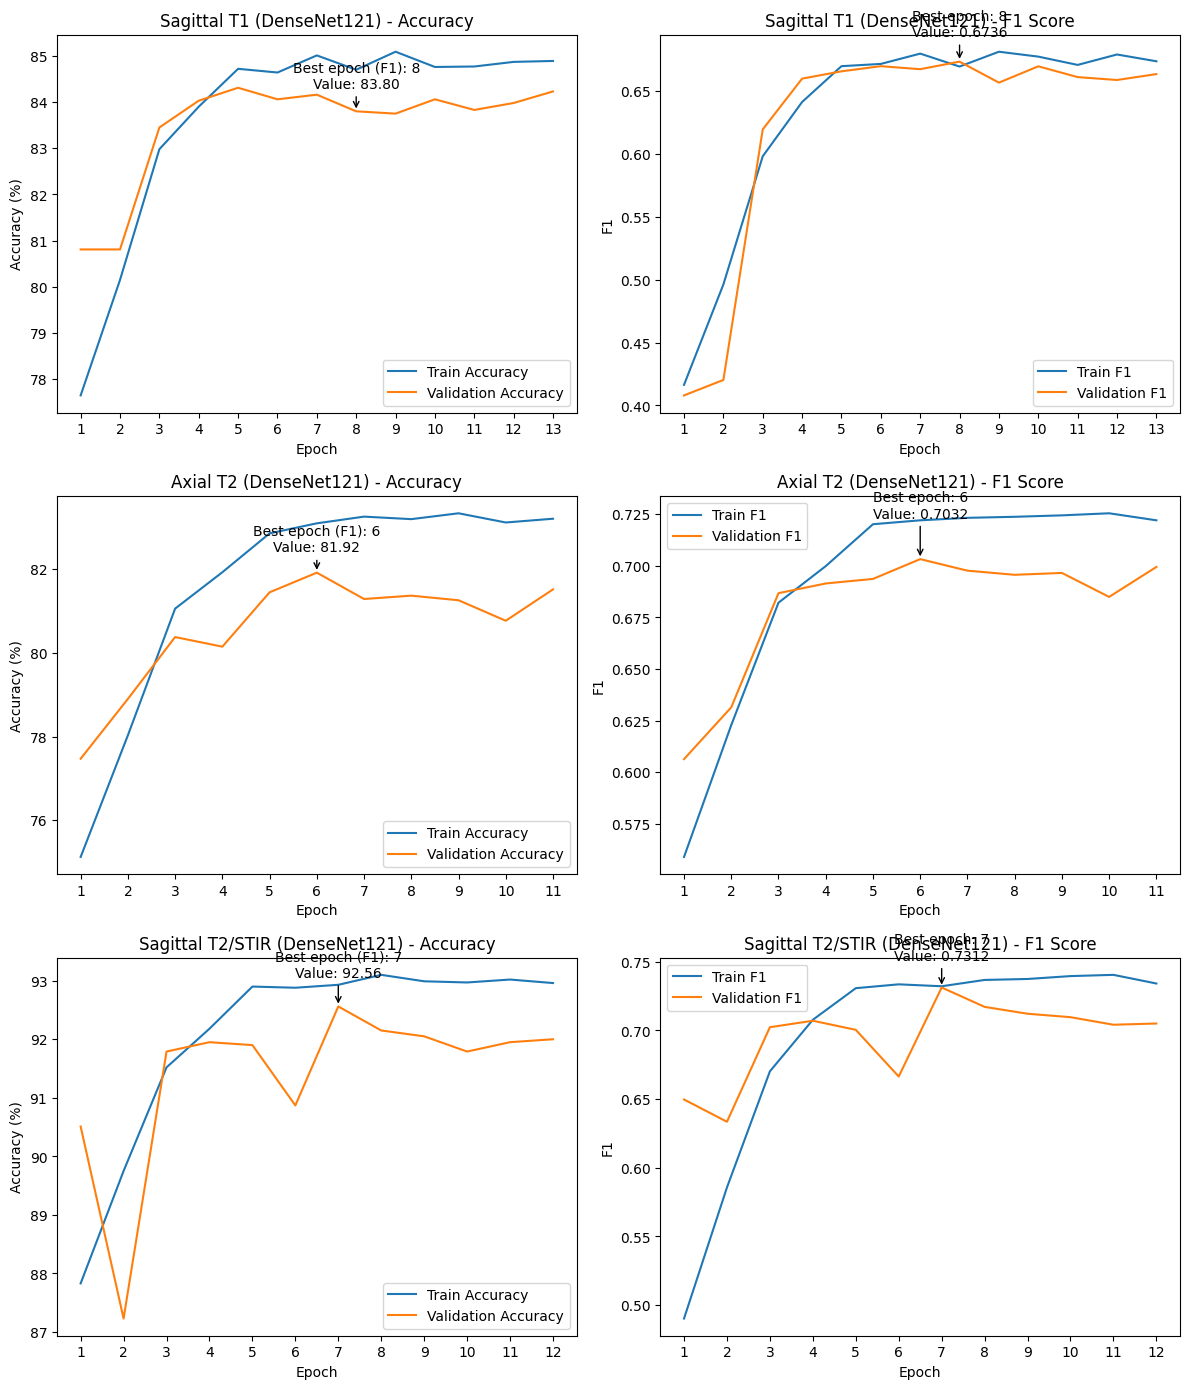

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 1) DATA DEFINITION
#    (All values taken directly from your DenseNet121 logs)
# ------------------------------------------------------------

# A) Sagittal T1 (13 epochs)
dense_t1_train_acc = [
    77.65, 80.15, 82.98, 83.90, 84.72,
    84.64, 85.01, 84.70, 85.09, 84.76,
    84.77, 84.87, 84.89
]
dense_t1_val_acc = [
    80.81, 80.81, 83.45, 84.03, 84.31,
    84.06, 84.16, 83.80, 83.75, 84.06,
    83.83, 83.98, 84.23
]
dense_t1_train_f1 = [
    0.4164, 0.4963, 0.5983, 0.6415, 0.6700,
    0.6718, 0.6800, 0.6697, 0.6815, 0.6776,
    0.6710, 0.6793, 0.6739
]
dense_t1_val_f1 = [
    0.4080, 0.4203, 0.6197, 0.6601, 0.6659,
    0.6700, 0.6676, 0.6736, 0.6569, 0.6699,
    0.6613, 0.6590, 0.6637
]

# B) Axial T2 (11 epochs)
dense_ax_t2_train_acc = [
    75.12, 78.03, 81.06, 81.93, 82.86,
    83.10, 83.26, 83.20, 83.34, 83.12,
    83.21
]
dense_ax_t2_val_acc = [
    77.47, 78.90, 80.38, 80.15, 81.45,
    81.92, 81.29, 81.37, 81.26, 80.77,
    81.52
]
dense_ax_t2_train_f1 = [
    0.5589, 0.6228, 0.6821, 0.6998, 0.7201,
    0.7220, 0.7232, 0.7237, 0.7244, 0.7254,
    0.7220
]
dense_ax_t2_val_f1 = [
    0.6063, 0.6314, 0.6867, 0.6914, 0.6936,
    0.7032, 0.6976, 0.6956, 0.6965, 0.6849,
    0.6994
]

# C) Sagittal T2/STIR (12 epochs)
dense_t2stir_train_acc = [
    87.83, 89.75, 91.52, 92.18, 92.90,
    92.88, 92.93, 93.10, 92.99, 92.97,
    93.02, 92.96
]
dense_t2stir_val_acc = [
    90.51, 87.23, 91.79, 91.95, 91.90,
    90.87, 92.56, 92.15, 92.05, 91.79,
    91.95, 92.00
]
dense_t2stir_train_f1 = [
    0.4903, 0.5857, 0.6702, 0.7077, 0.7307,
    0.7335, 0.7321, 0.7367, 0.7374, 0.7395,
    0.7404, 0.7341
]
dense_t2stir_val_f1 = [
    0.6497, 0.6335, 0.7023, 0.7070, 0.7004,
    0.6664, 0.7312, 0.7171, 0.7121, 0.7096,
    0.7041, 0.7050
]

# ------------------------------------------------------------
# 2) UTILITY: FUNCTION TO PLOT A SINGLE MODEL (2 subplots)
# ------------------------------------------------------------
def plot_model(ax_acc, ax_f1, train_acc, val_acc, train_f1, val_f1, title_str):
    """
    ax_acc, ax_f1 : matplotlib Axes objects for accuracy and f1 subplots
    train_acc, val_acc, train_f1, val_f1 : lists of metric values
    title_str : for labeling this model's row
    """

    epochs = np.arange(1, len(train_acc)+1)

    # ---- Accuracy subplot ----
    ax_acc.plot(epochs, train_acc, label='Train Accuracy')
    ax_acc.plot(epochs, val_acc, label='Validation Accuracy')
    ax_acc.set_title(f'{title_str} - Accuracy')
    ax_acc.set_xlabel('Epoch')
    ax_acc.set_ylabel('Accuracy (%)')
    ax_acc.set_xticks(epochs)
    ax_acc.legend(loc='best')

    # Find best epoch (highest val_f1)
    best_epoch_f1 = np.argmax(val_f1)
    best_epoch_f1_number = best_epoch_f1 + 1  # +1 because epochs are 1-indexed
    best_acc_at_f1 = val_acc[best_epoch_f1]   # validation ACC at that best-F1 epoch
    # Annotate on the accuracy subplot
    text_str_acc = f'Best epoch (F1): {best_epoch_f1_number}\nValue: {best_acc_at_f1:.2f}'
    ax_acc.annotate(
        text_str_acc,
        xy=(best_epoch_f1_number, best_acc_at_f1),
        xytext=(best_epoch_f1_number, best_acc_at_f1 + 0.5),
        arrowprops=dict(arrowstyle='->', color='black'),
        ha='center'
    )

    # ---- F1 subplot ----
    ax_f1.plot(epochs, train_f1, label='Train F1')
    ax_f1.plot(epochs, val_f1, label='Validation F1')
    ax_f1.set_title(f'{title_str} - F1 Score')
    ax_f1.set_xlabel('Epoch')
    ax_f1.set_ylabel('F1')
    ax_f1.set_xticks(epochs)
    ax_f1.legend(loc='best')

    # Highest val_f1:
    best_val_f1 = val_f1[best_epoch_f1]
    text_str_f1 = f'Best epoch: {best_epoch_f1_number}\nValue: {best_val_f1:.4f}'
    ax_f1.annotate(
        text_str_f1,
        xy=(best_epoch_f1_number, best_val_f1),
        xytext=(best_epoch_f1_number, best_val_f1 + 0.02),
        arrowprops=dict(arrowstyle='->', color='black'),
        ha='center'
    )

# ------------------------------------------------------------
# 3) MAIN PLOTTING
# ------------------------------------------------------------
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 14))

# Row 1: Sagittal T1
plot_model(
    axes[0,0],
    axes[0,1],
    dense_t1_train_acc,
    dense_t1_val_acc,
    dense_t1_train_f1,
    dense_t1_val_f1,
    "Sagittal T1 (DenseNet121)"
)

# Row 2: Axial T2
plot_model(
    axes[1,0],
    axes[1,1],
    dense_ax_t2_train_acc,
    dense_ax_t2_val_acc,
    dense_ax_t2_train_f1,
    dense_ax_t2_val_f1,
    "Axial T2 (DenseNet121)"
)

# Row 3: Sagittal T2/STIR
plot_model(
    axes[2,0],
    axes[2,1],
    dense_t2stir_train_acc,
    dense_t2stir_val_acc,
    dense_t2stir_train_f1,
    dense_t2stir_val_f1,
    "Sagittal T2/STIR (DenseNet121)"
)

plt.tight_layout()
plt.show()


##EfficientNetV2

In [ ]:
# Training all models
for desc, model in models.items():
    if desc == 'Sagittal T1':
        criterion = criterion_t1
        trainloader, valloader, len_train, len_val = trainloader_t1, valloader_t1, len_train_t1, len_val_t1
    elif desc == 'Axial T2':
        criterion = criterion_t2
        trainloader, valloader, len_train, len_val = trainloader_t2, valloader_t2, len_train_t2, len_val_t2
    elif desc == 'Sagittal T2/STIR':
        criterion = criterion_t2stir
        trainloader, valloader, len_train, len_val = trainloader_t2stir, valloader_t2stir, len_train_t2stir, len_val_t2stir

    print(f"Training model for {desc}")
    train_model(model, trainloader, valloader, len_train, len_val, optimizers[desc])

Training model for Sagittal T1


100%|██████████| 124/124 [00:32<00:00,  3.84batch/s, epoch=1]


Epoch 1:
Train Loss: 0.0592, Train Acc: 77.17%, Train Precision: 0.3331, Train Recall: 0.3332, Train F1: 0.2985
Val Loss: 0.0547, Val Acc: 77.99%, Val Precision: 0.2600, Val Recall: 0.3333, Val F1: 0.2921 



100%|██████████| 124/124 [00:32<00:00,  3.85batch/s, epoch=2]


Epoch 2:
Train Loss: 0.0529, Train Acc: 77.35%, Train Precision: 0.3840, Train Recall: 0.3354, Train F1: 0.3021
Val Loss: 0.0470, Val Acc: 78.40%, Val Precision: 0.4517, Val Recall: 0.3441, Val F1: 0.3152 



100%|██████████| 124/124 [00:32<00:00,  3.86batch/s, epoch=3]


Epoch 3:
Train Loss: 0.0461, Train Acc: 77.98%, Train Precision: 0.5023, Train Recall: 0.3730, Train F1: 0.3722
Val Loss: 0.0455, Val Acc: 78.29%, Val Precision: 0.5857, Val Recall: 0.3910, Val F1: 0.3929 



100%|██████████| 124/124 [00:32<00:00,  3.85batch/s, epoch=4]


Epoch 4:
Train Loss: 0.0408, Train Acc: 78.81%, Train Precision: 0.5274, Train Recall: 0.4153, Train F1: 0.4324
Val Loss: 0.0399, Val Acc: 77.91%, Val Precision: 0.5665, Val Recall: 0.5104, Val F1: 0.5173 



100%|██████████| 124/124 [00:32<00:00,  3.87batch/s, epoch=5]


Epoch 5:
Train Loss: 0.0379, Train Acc: 79.82%, Train Precision: 0.5878, Train Recall: 0.4689, Train F1: 0.4998
Val Loss: 0.0354, Val Acc: 81.72%, Val Precision: 0.6476, Val Recall: 0.4329, Val F1: 0.4535 



100%|██████████| 124/124 [00:32<00:00,  3.86batch/s, epoch=6]


Epoch 6:
Train Loss: 0.0357, Train Acc: 80.30%, Train Precision: 0.5937, Train Recall: 0.4904, Train F1: 0.5215
Val Loss: 0.0339, Val Acc: 80.88%, Val Precision: 0.6165, Val Recall: 0.4340, Val F1: 0.4524 



100%|██████████| 124/124 [00:32<00:00,  3.81batch/s, epoch=7]


Epoch 7:
Train Loss: 0.0347, Train Acc: 80.16%, Train Precision: 0.5835, Train Recall: 0.4936, Train F1: 0.5218
Val Loss: 0.0415, Val Acc: 72.66%, Val Precision: 0.5544, Val Recall: 0.5424, Val F1: 0.5124 



100%|██████████| 124/124 [00:32<00:00,  3.86batch/s, epoch=8]


Epoch 8:
Train Loss: 0.0336, Train Acc: 80.91%, Train Precision: 0.6171, Train Recall: 0.5142, Train F1: 0.5476
Val Loss: 0.0399, Val Acc: 81.59%, Val Precision: 0.6505, Val Recall: 0.5260, Val F1: 0.5519 



100%|██████████| 124/124 [00:32<00:00,  3.85batch/s, epoch=9]


Epoch 9:
Train Loss: 0.0322, Train Acc: 81.09%, Train Precision: 0.6303, Train Recall: 0.5311, Train F1: 0.5649
Val Loss: 0.0303, Val Acc: 82.10%, Val Precision: 0.6100, Val Recall: 0.6211, Val F1: 0.6020 



100%|██████████| 124/124 [00:32<00:00,  3.80batch/s, epoch=10]


Epoch 10:
Train Loss: 0.0313, Train Acc: 81.24%, Train Precision: 0.6189, Train Recall: 0.5409, Train F1: 0.5700
Val Loss: 0.0311, Val Acc: 82.28%, Val Precision: 0.6301, Val Recall: 0.4744, Val F1: 0.4983 



100%|██████████| 124/124 [00:31<00:00,  3.88batch/s, epoch=11]


Epoch 11:
Train Loss: 0.0301, Train Acc: 81.79%, Train Precision: 0.6379, Train Recall: 0.5492, Train F1: 0.5817
Val Loss: 0.0290, Val Acc: 82.84%, Val Precision: 0.6770, Val Recall: 0.5774, Val F1: 0.6109 



100%|██████████| 124/124 [00:31<00:00,  3.90batch/s, epoch=12]


Epoch 12:
Train Loss: 0.0293, Train Acc: 82.44%, Train Precision: 0.6725, Train Recall: 0.5789, Train F1: 0.6144
Val Loss: 0.0294, Val Acc: 83.22%, Val Precision: 0.6687, Val Recall: 0.5972, Val F1: 0.6256 



100%|██████████| 124/124 [00:32<00:00,  3.83batch/s, epoch=13]


Epoch 13:
Train Loss: 0.0277, Train Acc: 82.98%, Train Precision: 0.6708, Train Recall: 0.5843, Train F1: 0.6178
Val Loss: 0.0285, Val Acc: 81.67%, Val Precision: 0.6066, Val Recall: 0.6580, Val F1: 0.6165 



100%|██████████| 124/124 [00:32<00:00,  3.82batch/s, epoch=14]


Epoch 14:
Train Loss: 0.0265, Train Acc: 82.99%, Train Precision: 0.6782, Train Recall: 0.6052, Train F1: 0.6346
Val Loss: 0.0255, Val Acc: 83.96%, Val Precision: 0.6664, Val Recall: 0.6359, Val F1: 0.6453 



100%|██████████| 124/124 [00:32<00:00,  3.85batch/s, epoch=15]


Epoch 15:
Train Loss: 0.0249, Train Acc: 83.63%, Train Precision: 0.7017, Train Recall: 0.6289, Train F1: 0.6592
Val Loss: 0.0277, Val Acc: 83.09%, Val Precision: 0.6826, Val Recall: 0.5804, Val F1: 0.6156 



100%|██████████| 124/124 [00:32<00:00,  3.86batch/s, epoch=16]


Epoch 16:
Train Loss: 0.0235, Train Acc: 84.27%, Train Precision: 0.7062, Train Recall: 0.6491, Train F1: 0.6731
Val Loss: 0.0238, Val Acc: 84.44%, Val Precision: 0.7054, Val Recall: 0.6356, Val F1: 0.6612 



100%|██████████| 124/124 [00:31<00:00,  3.88batch/s, epoch=17]


Epoch 17:
Train Loss: 0.0219, Train Acc: 84.75%, Train Precision: 0.7216, Train Recall: 0.6534, Train F1: 0.6819
Val Loss: 0.0262, Val Acc: 82.94%, Val Precision: 0.6384, Val Recall: 0.6860, Val F1: 0.6545 



100%|██████████| 124/124 [00:32<00:00,  3.84batch/s, epoch=18]


Epoch 18:
Train Loss: 0.0200, Train Acc: 85.16%, Train Precision: 0.7291, Train Recall: 0.6819, Train F1: 0.7017
Val Loss: 0.0230, Val Acc: 85.17%, Val Precision: 0.7156, Val Recall: 0.6384, Val F1: 0.6700 



100%|██████████| 124/124 [00:32<00:00,  3.81batch/s, epoch=19]


Epoch 19:
Train Loss: 0.0196, Train Acc: 85.59%, Train Precision: 0.7405, Train Recall: 0.6933, Train F1: 0.7128
Val Loss: 0.0238, Val Acc: 85.02%, Val Precision: 0.7029, Val Recall: 0.6657, Val F1: 0.6818 



100%|██████████| 124/124 [00:32<00:00,  3.84batch/s, epoch=20]


Epoch 20:
Train Loss: 0.0190, Train Acc: 85.44%, Train Precision: 0.7374, Train Recall: 0.6945, Train F1: 0.7128
Val Loss: 0.0245, Val Acc: 84.69%, Val Precision: 0.6824, Val Recall: 0.6589, Val F1: 0.6663 

Training model for Axial T2


100%|██████████| 121/121 [00:27<00:00,  4.42batch/s, epoch=1]


Epoch 1:
Train Loss: 0.0776, Train Acc: 69.00%, Train Precision: 0.3500, Train Recall: 0.3372, Train F1: 0.3059
Val Loss: 0.0755, Val Acc: 71.40%, Val Precision: 0.2380, Val Recall: 0.3333, Val F1: 0.2777 



100%|██████████| 121/121 [00:27<00:00,  4.35batch/s, epoch=2]


Epoch 2:
Train Loss: 0.0713, Train Acc: 70.85%, Train Precision: 0.4102, Train Recall: 0.3385, Train F1: 0.2951
Val Loss: 0.0617, Val Acc: 71.66%, Val Precision: 0.4547, Val Recall: 0.3432, Val F1: 0.2974 



100%|██████████| 121/121 [00:27<00:00,  4.35batch/s, epoch=3]


Epoch 3:
Train Loss: 0.0593, Train Acc: 71.72%, Train Precision: 0.4885, Train Recall: 0.4049, Train F1: 0.4056
Val Loss: 0.0535, Val Acc: 74.37%, Val Precision: 0.5568, Val Recall: 0.5064, Val F1: 0.4657 



100%|██████████| 121/121 [00:27<00:00,  4.41batch/s, epoch=4]


Epoch 4:
Train Loss: 0.0520, Train Acc: 74.20%, Train Precision: 0.5549, Train Recall: 0.5050, Train F1: 0.5170
Val Loss: 0.0537, Val Acc: 72.89%, Val Precision: 0.7479, Val Recall: 0.4766, Val F1: 0.4417 



100%|██████████| 121/121 [00:28<00:00,  4.30batch/s, epoch=5]


Epoch 5:
Train Loss: 0.0490, Train Acc: 75.50%, Train Precision: 0.5887, Train Recall: 0.5407, Train F1: 0.5570
Val Loss: 0.0511, Val Acc: 74.86%, Val Precision: 0.6409, Val Recall: 0.4809, Val F1: 0.5100 



100%|██████████| 121/121 [00:27<00:00,  4.39batch/s, epoch=6]


Epoch 6:
Train Loss: 0.0456, Train Acc: 76.86%, Train Precision: 0.6086, Train Recall: 0.5703, Train F1: 0.5839
Val Loss: 0.0451, Val Acc: 75.67%, Val Precision: 0.5873, Val Recall: 0.6392, Val F1: 0.5879 



100%|██████████| 121/121 [00:27<00:00,  4.38batch/s, epoch=7]


Epoch 7:
Train Loss: 0.0437, Train Acc: 77.22%, Train Precision: 0.6206, Train Recall: 0.5955, Train F1: 0.6040
Val Loss: 0.0485, Val Acc: 77.44%, Val Precision: 0.6194, Val Recall: 0.5890, Val F1: 0.5822 



100%|██████████| 121/121 [00:27<00:00,  4.32batch/s, epoch=8]


Epoch 8:
Train Loss: 0.0422, Train Acc: 77.60%, Train Precision: 0.6242, Train Recall: 0.6028, Train F1: 0.6101
Val Loss: 0.0568, Val Acc: 70.31%, Val Precision: 0.5618, Val Recall: 0.6725, Val F1: 0.5836 



100%|██████████| 121/121 [00:27<00:00,  4.37batch/s, epoch=9]


Epoch 9:
Train Loss: 0.0404, Train Acc: 78.40%, Train Precision: 0.6451, Train Recall: 0.6185, Train F1: 0.6293
Val Loss: 0.0435, Val Acc: 78.74%, Val Precision: 0.6667, Val Recall: 0.6042, Val F1: 0.6287 



100%|██████████| 121/121 [00:27<00:00,  4.33batch/s, epoch=10]


Epoch 10:
Train Loss: 0.0389, Train Acc: 78.68%, Train Precision: 0.6516, Train Recall: 0.6238, Train F1: 0.6356
Val Loss: 0.0467, Val Acc: 76.81%, Val Precision: 0.6239, Val Recall: 0.6511, Val F1: 0.6350 



100%|██████████| 121/121 [00:28<00:00,  4.31batch/s, epoch=11]


Epoch 11:
Train Loss: 0.0381, Train Acc: 79.34%, Train Precision: 0.6647, Train Recall: 0.6362, Train F1: 0.6484
Val Loss: 0.0381, Val Acc: 79.31%, Val Precision: 0.6661, Val Recall: 0.6785, Val F1: 0.6716 



100%|██████████| 121/121 [00:27<00:00,  4.34batch/s, epoch=12]


Epoch 12:
Train Loss: 0.0367, Train Acc: 79.55%, Train Precision: 0.6656, Train Recall: 0.6442, Train F1: 0.6532
Val Loss: 0.0430, Val Acc: 77.70%, Val Precision: 0.6558, Val Recall: 0.6356, Val F1: 0.6445 



100%|██████████| 121/121 [00:28<00:00,  4.32batch/s, epoch=13]


Epoch 13:
Train Loss: 0.0349, Train Acc: 80.42%, Train Precision: 0.6864, Train Recall: 0.6603, Train F1: 0.6719
Val Loss: 0.0366, Val Acc: 80.04%, Val Precision: 0.7031, Val Recall: 0.6516, Val F1: 0.6720 



100%|██████████| 121/121 [00:27<00:00,  4.34batch/s, epoch=14]


Epoch 14:
Train Loss: 0.0345, Train Acc: 80.33%, Train Precision: 0.6835, Train Recall: 0.6585, Train F1: 0.6697
Val Loss: 0.0369, Val Acc: 80.30%, Val Precision: 0.6955, Val Recall: 0.6892, Val F1: 0.6920 



100%|██████████| 121/121 [00:27<00:00,  4.36batch/s, epoch=15]


Epoch 15:
Train Loss: 0.0321, Train Acc: 81.47%, Train Precision: 0.7012, Train Recall: 0.6821, Train F1: 0.6903
Val Loss: 0.0352, Val Acc: 80.82%, Val Precision: 0.6980, Val Recall: 0.6841, Val F1: 0.6906 



100%|██████████| 121/121 [00:27<00:00,  4.34batch/s, epoch=16]


Epoch 16:
Train Loss: 0.0301, Train Acc: 81.99%, Train Precision: 0.7107, Train Recall: 0.6958, Train F1: 0.7021
Val Loss: 0.0354, Val Acc: 81.32%, Val Precision: 0.7170, Val Recall: 0.6557, Val F1: 0.6805 



100%|██████████| 121/121 [00:27<00:00,  4.35batch/s, epoch=17]


Epoch 17:
Train Loss: 0.0276, Train Acc: 82.15%, Train Precision: 0.7166, Train Recall: 0.6949, Train F1: 0.7043
Val Loss: 0.0345, Val Acc: 81.16%, Val Precision: 0.6983, Val Recall: 0.6941, Val F1: 0.6955 



100%|██████████| 121/121 [00:28<00:00,  4.31batch/s, epoch=18]


Epoch 18:
Train Loss: 0.0267, Train Acc: 83.24%, Train Precision: 0.7354, Train Recall: 0.7150, Train F1: 0.7237
Val Loss: 0.0359, Val Acc: 80.87%, Val Precision: 0.6929, Val Recall: 0.6737, Val F1: 0.6818 



100%|██████████| 121/121 [00:28<00:00,  4.31batch/s, epoch=19]


Epoch 19:
Train Loss: 0.0243, Train Acc: 83.73%, Train Precision: 0.7453, Train Recall: 0.7280, Train F1: 0.7356
Val Loss: 0.0373, Val Acc: 81.32%, Val Precision: 0.7029, Val Recall: 0.6907, Val F1: 0.6961 



100%|██████████| 121/121 [00:27<00:00,  4.34batch/s, epoch=20]


Epoch 20:
Train Loss: 0.0240, Train Acc: 83.80%, Train Precision: 0.7515, Train Recall: 0.7261, Train F1: 0.7377
Val Loss: 0.0374, Val Acc: 81.32%, Val Precision: 0.7084, Val Recall: 0.6822, Val F1: 0.6936 

Training model for Sagittal T2/STIR


100%|██████████| 61/61 [00:15<00:00,  3.96batch/s, epoch=1]


Epoch 1:
Train Loss: 0.0512, Train Acc: 84.93%, Train Precision: 0.3069, Train Recall: 0.3275, Train F1: 0.3135
Val Loss: 0.0407, Val Acc: 87.69%, Val Precision: 0.2923, Val Recall: 0.3333, Val F1: 0.3115 



100%|██████████| 61/61 [00:15<00:00,  3.96batch/s, epoch=2]


Epoch 2:
Train Loss: 0.0377, Train Acc: 87.52%, Train Precision: 0.4463, Train Recall: 0.3375, Train F1: 0.3212
Val Loss: 0.0363, Val Acc: 87.69%, Val Precision: 0.2923, Val Recall: 0.3333, Val F1: 0.3115 



100%|██████████| 61/61 [00:15<00:00,  3.98batch/s, epoch=3]


Epoch 3:
Train Loss: 0.0314, Train Acc: 88.21%, Train Precision: 0.5818, Train Recall: 0.4289, Train F1: 0.4580
Val Loss: 0.0266, Val Acc: 89.38%, Val Precision: 0.6697, Val Recall: 0.5236, Val F1: 0.5052 



100%|██████████| 61/61 [00:15<00:00,  3.87batch/s, epoch=4]


Epoch 4:
Train Loss: 0.0256, Train Acc: 89.48%, Train Precision: 0.6231, Train Recall: 0.5271, Train F1: 0.5575
Val Loss: 0.0283, Val Acc: 88.26%, Val Precision: 0.5874, Val Recall: 0.6636, Val F1: 0.6041 



100%|██████████| 61/61 [00:15<00:00,  3.93batch/s, epoch=5]


Epoch 5:
Train Loss: 0.0248, Train Acc: 89.63%, Train Precision: 0.6237, Train Recall: 0.5381, Train F1: 0.5670
Val Loss: 0.0218, Val Acc: 90.36%, Val Precision: 0.6405, Val Recall: 0.6223, Val F1: 0.5783 



100%|██████████| 61/61 [00:15<00:00,  3.86batch/s, epoch=6]


Epoch 6:
Train Loss: 0.0223, Train Acc: 90.24%, Train Precision: 0.6589, Train Recall: 0.5824, Train F1: 0.6067
Val Loss: 0.0248, Val Acc: 90.77%, Val Precision: 0.6617, Val Recall: 0.5962, Val F1: 0.6142 



100%|██████████| 61/61 [00:15<00:00,  3.92batch/s, epoch=7]


Epoch 7:
Train Loss: 0.0242, Train Acc: 89.77%, Train Precision: 0.6323, Train Recall: 0.5615, Train F1: 0.5880
Val Loss: 0.0252, Val Acc: 88.21%, Val Precision: 0.5832, Val Recall: 0.4290, Val F1: 0.4604 



100%|██████████| 61/61 [00:15<00:00,  3.88batch/s, epoch=8]


Epoch 8:
Train Loss: 0.0231, Train Acc: 90.02%, Train Precision: 0.6378, Train Recall: 0.5741, Train F1: 0.5963
Val Loss: 0.0210, Val Acc: 90.67%, Val Precision: 0.6618, Val Recall: 0.6656, Val F1: 0.6622 



100%|██████████| 61/61 [00:15<00:00,  3.88batch/s, epoch=9]


Epoch 9:
Train Loss: 0.0204, Train Acc: 90.69%, Train Precision: 0.6746, Train Recall: 0.6203, Train F1: 0.6403
Val Loss: 0.0213, Val Acc: 90.10%, Val Precision: 0.6675, Val Recall: 0.6047, Val F1: 0.6231 



100%|██████████| 61/61 [00:15<00:00,  3.94batch/s, epoch=10]


Epoch 10:
Train Loss: 0.0200, Train Acc: 90.84%, Train Precision: 0.6776, Train Recall: 0.6256, Train F1: 0.6448
Val Loss: 0.0244, Val Acc: 88.67%, Val Precision: 0.5979, Val Recall: 0.6802, Val F1: 0.6281 



100%|██████████| 61/61 [00:15<00:00,  3.94batch/s, epoch=11]


Epoch 11:
Train Loss: 0.0198, Train Acc: 91.27%, Train Precision: 0.7039, Train Recall: 0.6403, Train F1: 0.6663
Val Loss: 0.0206, Val Acc: 91.03%, Val Precision: 0.6869, Val Recall: 0.6184, Val F1: 0.6465 



100%|██████████| 61/61 [00:15<00:00,  3.93batch/s, epoch=12]


Epoch 12:
Train Loss: 0.0182, Train Acc: 91.42%, Train Precision: 0.7010, Train Recall: 0.6436, Train F1: 0.6668
Val Loss: 0.0231, Val Acc: 88.21%, Val Precision: 0.6549, Val Recall: 0.6207, Val F1: 0.5900 



100%|██████████| 61/61 [00:15<00:00,  3.93batch/s, epoch=13]

Epoch 13:
Train Loss: 0.0174, Train Acc: 91.52%, Train Precision: 0.7042, Train Recall: 0.6584, Train F1: 0.6779
Val Loss: 0.0195, Val Acc: 90.72%, Val Precision: 0.6670, Val Recall: 0.5829, Val F1: 0.6171 

Early stopping triggered after 13 epochs



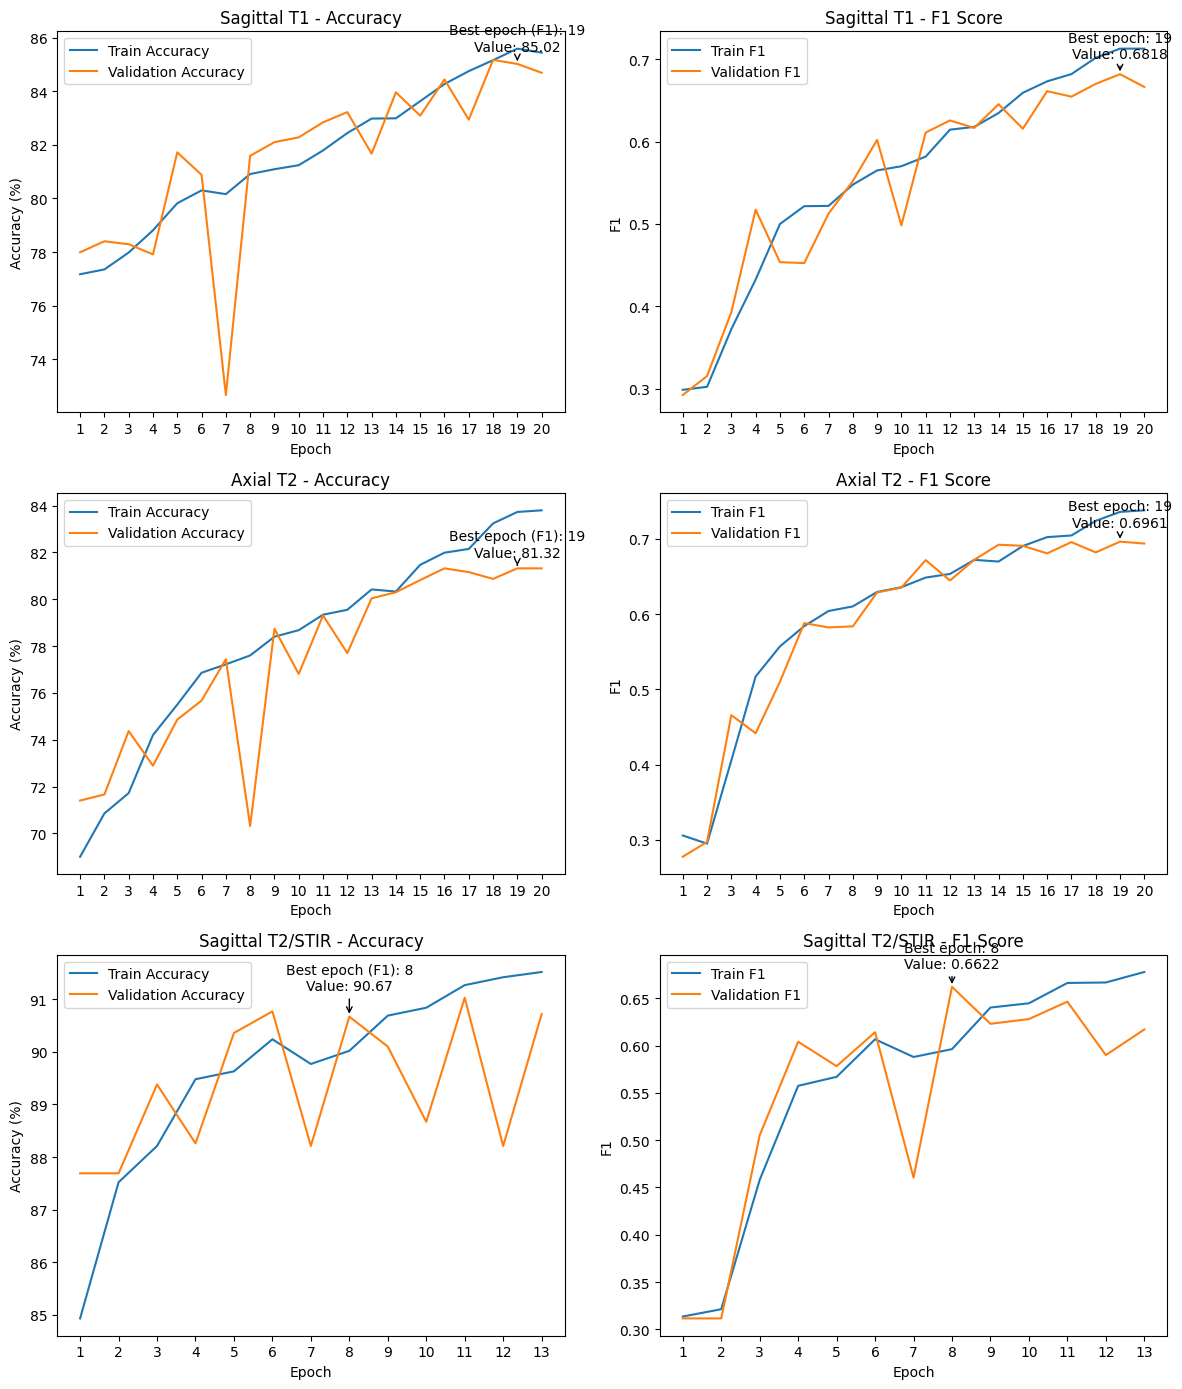

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 1) DATA DEFINITION
#    (All values taken directly from your logs, in the same order)
# ------------------------------------------------------------

# A) Sagittal T1 (20 epochs)
sag_t1_train_acc = [
    77.17, 77.35, 77.98, 78.81, 79.82,
    80.30, 80.16, 80.91, 81.09, 81.24,
    81.79, 82.44, 82.98, 82.99, 83.63,
    84.27, 84.75, 85.16, 85.59, 85.44
]
sag_t1_val_acc = [
    77.99, 78.40, 78.29, 77.91, 81.72,
    80.88, 72.66, 81.59, 82.10, 82.28,
    82.84, 83.22, 81.67, 83.96, 83.09,
    84.44, 82.94, 85.17, 85.02, 84.69
]
sag_t1_train_f1 = [
    0.2985, 0.3021, 0.3722, 0.4324, 0.4998,
    0.5215, 0.5218, 0.5476, 0.5649, 0.5700,
    0.5817, 0.6144, 0.6178, 0.6346, 0.6592,
    0.6731, 0.6819, 0.7017, 0.7128, 0.7128
]
sag_t1_val_f1 = [
    0.2921, 0.3152, 0.3929, 0.5173, 0.4535,
    0.4524, 0.5124, 0.5519, 0.6020, 0.4983,
    0.6109, 0.6256, 0.6165, 0.6453, 0.6156,
    0.6612, 0.6545, 0.6700, 0.6818, 0.6663
]

# B) Axial T2 (20 epochs)
ax_t2_train_acc = [
    69.00, 70.85, 71.72, 74.20, 75.50,
    76.86, 77.22, 77.60, 78.40, 78.68,
    79.34, 79.55, 80.42, 80.33, 81.47,
    81.99, 82.15, 83.24, 83.73, 83.80
]
ax_t2_val_acc = [
    71.40, 71.66, 74.37, 72.89, 74.86,
    75.67, 77.44, 70.31, 78.74, 76.81,
    79.31, 77.70, 80.04, 80.30, 80.82,
    81.32, 81.16, 80.87, 81.32, 81.32
]
ax_t2_train_f1 = [
    0.3059, 0.2951, 0.4056, 0.5170, 0.5570,
    0.5839, 0.6040, 0.6101, 0.6293, 0.6356,
    0.6484, 0.6532, 0.6719, 0.6697, 0.6903,
    0.7021, 0.7043, 0.7237, 0.7356, 0.7377
]
ax_t2_val_f1 = [
    0.2777, 0.2974, 0.4657, 0.4417, 0.5100,
    0.5879, 0.5822, 0.5836, 0.6287, 0.6350,
    0.6716, 0.6445, 0.6720, 0.6920, 0.6906,
    0.6805, 0.6955, 0.6818, 0.6961, 0.6936
]

# C) Sagittal T2/STIR (13 epochs + early stop)
sag_t2stir_train_acc = [
    84.93, 87.52, 88.21, 89.48, 89.63,
    90.24, 89.77, 90.02, 90.69, 90.84,
    91.27, 91.42, 91.52
]
sag_t2stir_val_acc = [
    87.69, 87.69, 89.38, 88.26, 90.36,
    90.77, 88.21, 90.67, 90.10, 88.67,
    91.03, 88.21, 90.72
]
sag_t2stir_train_f1 = [
    0.3135, 0.3212, 0.4580, 0.5575, 0.5670,
    0.6067, 0.5880, 0.5963, 0.6403, 0.6448,
    0.6663, 0.6668, 0.6779
]
sag_t2stir_val_f1 = [
    0.3115, 0.3115, 0.5052, 0.6041, 0.5783,
    0.6142, 0.4604, 0.6622, 0.6231, 0.6281,
    0.6465, 0.5900, 0.6171
]

# ------------------------------------------------------------
# 2) UTILITY: FUNCTION TO PLOT A SINGLE MODEL (2 subplots)
# ------------------------------------------------------------
def plot_model(ax_acc, ax_f1, train_acc, val_acc, train_f1, val_f1, title_str):
    """
    ax_acc, ax_f1 : matplotlib Axes objects for accuracy and f1 subplots
    train_acc, val_acc, train_f1, val_f1 : lists of metric values
    title_str : for labeling this model's row
    """

    epochs = np.arange(1, len(train_acc)+1)

    # ---- Accuracy subplot ----
    ax_acc.plot(epochs, train_acc, label='Train Accuracy')
    ax_acc.plot(epochs, val_acc, label='Validation Accuracy')
    ax_acc.set_title(f'{title_str} - Accuracy')
    ax_acc.set_xlabel('Epoch')
    ax_acc.set_ylabel('Accuracy (%)')
    ax_acc.set_xticks(epochs)
    ax_acc.legend(loc='best')

    # Find best epoch (based on highest val_f1)
    best_epoch_f1 = np.argmax(val_f1)
    best_epoch_f1_number = best_epoch_f1 + 1  # +1 because epochs are 1-indexed
    best_acc_at_f1 = val_acc[best_epoch_f1]   # validation ACC at that best-F1 epoch
    # Annotate on the accuracy subplot
    text_str_acc = f'Best epoch (F1): {best_epoch_f1_number}\nValue: {best_acc_at_f1:.2f}'
    # A small offset in y to place the text above the point
    ax_acc.annotate(
        text_str_acc,
        xy=(best_epoch_f1_number, best_acc_at_f1),
        xytext=(best_epoch_f1_number, best_acc_at_f1 + 0.5),
        arrowprops=dict(arrowstyle='->', color='black'),
        ha='center'
    )

    # ---- F1 subplot ----
    ax_f1.plot(epochs, train_f1, label='Train F1')
    ax_f1.plot(epochs, val_f1, label='Validation F1')
    ax_f1.set_title(f'{title_str} - F1 Score')
    ax_f1.set_xlabel('Epoch')
    ax_f1.set_ylabel('F1')
    ax_f1.set_xticks(epochs)
    ax_f1.legend(loc='best')

    # Highest val_f1:
    best_val_f1 = val_f1[best_epoch_f1]
    text_str_f1 = f'Best epoch: {best_epoch_f1_number}\nValue: {best_val_f1:.4f}'
    ax_f1.annotate(
        text_str_f1,
        xy=(best_epoch_f1_number, best_val_f1),
        xytext=(best_epoch_f1_number, best_val_f1 + 0.02),
        arrowprops=dict(arrowstyle='->', color='black'),
        ha='center'
    )

# ------------------------------------------------------------
# 3) MAIN PLOTTING
# ------------------------------------------------------------
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 14))

# Row 1: Sagittal T1
plot_model(axes[0,0],
           axes[0,1],
           sag_t1_train_acc,
           sag_t1_val_acc,
           sag_t1_train_f1,
           sag_t1_val_f1,
           "Sagittal T1")

# Row 2: Axial T2
plot_model(axes[1,0],
           axes[1,1],
           ax_t2_train_acc,
           ax_t2_val_acc,
           ax_t2_train_f1,
           ax_t2_val_f1,
           "Axial T2")

# Row 3: Sagittal T2/STIR
plot_model(axes[2,0],
           axes[2,1],
           sag_t2stir_train_acc,
           sag_t2stir_val_acc,
           sag_t2stir_train_f1,
           sag_t2stir_val_f1,
           "Sagittal T2/STIR")

plt.tight_layout()
plt.show()


In [ ]:
import torch

# Define the path where you want to save the model
base_dir = "/content/drive/MyDrive/FYPDataset/rsna-2024-lumbar-spine-degenerative-classification/convnextcbam_models"



# Loop through and save each model
for model_name, model in models.items():
    # ✅ Fix: Replace spaces with underscores in filenames
    clean_model_name = model_name.replace(" ", "_").replace("/", "_")

    save_path = os.path.join(base_dir, f"{clean_model_name}.pth")  # Save each model with its name
    torch.save(model.state_dict(), save_path)
    print(f"✅ Model {model_name} saved to {save_path}")

print(f"Models saved to {base_dir}")


✅ Model Sagittal T1 saved to densenetcbam_models/Sagittal_T1.pth
✅ Model Axial T2 saved to densenetcbam_models/Axial_T2.pth
✅ Model Sagittal T2/STIR saved to densenetcbam_models/Sagittal_T2_STIR.pth
Models saved to densenetcbam_models
